# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
rides.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

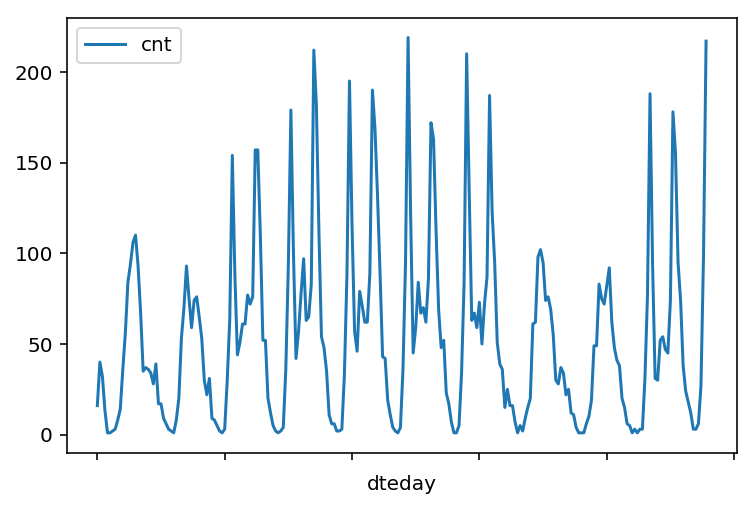

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [10]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from myanswers import NeuralNetwork

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

qtdade observações:  1



----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [13]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from myanswers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.433qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.433qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.434

C:\Users\lorra\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.0% ... Training loss: 0.986 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.431qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.432qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.432qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.433qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.433qtdade observações:  128
Progress: 0.1% ... Training loss: 0.985 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.1% ... Training loss: 0.986 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.1% ... Training loss: 0.986 ... Validation loss: 1.43

Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.436qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.437qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.436qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.434qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.3% ... Training loss: 0.985 ... Validation loss: 1.435qtdade observações:  128
Progress: 0.3% ... Training loss: 0.984 ... Validation loss: 1.432qtdade observações:  128
Progress: 0.4% ... Training loss: 0.984 ... Validation loss: 1.433qtdade observações:  128

Progress: 0.6% ... Training loss: 0.981 ... Validation loss: 1.418qtdade observações:  128
Progress: 0.6% ... Training loss: 0.981 ... Validation loss: 1.418qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.417qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.418qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.416qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.417qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.418qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.417qtdade observações:  128
Progress: 0.6% ... Training loss: 0.980 ... Validation loss: 1.416qtdade observações:  128
Progress: 0.7% ... Training loss: 0.980 ... Validation loss: 1.416qtdade observações:  128
Progress: 0.7% ... Training loss: 0.980 ... Validation loss: 1.417qtdade observações:  128

Progress: 0.9% ... Training loss: 0.982 ... Validation loss: 1.430qtdade observações:  128
Progress: 0.9% ... Training loss: 0.982 ... Validation loss: 1.430qtdade observações:  128
Progress: 0.9% ... Training loss: 0.982 ... Validation loss: 1.431qtdade observações:  128
Progress: 0.9% ... Training loss: 0.982 ... Validation loss: 1.431qtdade observações:  128
Progress: 0.9% ... Training loss: 0.981 ... Validation loss: 1.428qtdade observações:  128
Progress: 0.9% ... Training loss: 0.982 ... Validation loss: 1.428qtdade observações:  128
Progress: 0.9% ... Training loss: 0.981 ... Validation loss: 1.426qtdade observações:  128
Progress: 0.9% ... Training loss: 0.981 ... Validation loss: 1.426qtdade observações:  128
Progress: 0.9% ... Training loss: 0.981 ... Validation loss: 1.427qtdade observações:  128
Progress: 0.9% ... Training loss: 0.981 ... Validation loss: 1.428qtdade observações:  128
Progress: 1.0% ... Training loss: 0.981 ... Validation loss: 1.427qtdade observações:  128

Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.419qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.419qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.419qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.418qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.419qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.419qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.420qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.420qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.420qtdade observações:  128
Progress: 1.2% ... Training loss: 0.979 ... Validation loss: 1.418qtdade observações:  128
Progress: 1.3% ... Training loss: 0.979 ... Validation loss: 1.418qtdade observações:  128

Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.403qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.403qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.402qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.401qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.401qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.402qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.403qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.403qtdade observações:  128
Progress: 1.5% ... Training loss: 0.975 ... Validation loss: 1.404qtdade observações:  128
Progress: 1.6% ... Training loss: 0.975 ... Validation loss: 1.405qtdade observações:  128
Progress: 1.6% ... Training loss: 0.975 ... Validation loss: 1.403qtdade observações:  128

Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.414qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.413qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.414qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.415qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.414qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.413qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.413qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.414qtdade observações:  128
Progress: 1.8% ... Training loss: 0.976 ... Validation loss: 1.414qtdade observações:  128
Progress: 1.9% ... Training loss: 0.976 ... Validation loss: 1.415qtdade observações:  128
Progress: 1.9% ... Training loss: 0.976 ... Validation loss: 1.415qtdade observações:  128

Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.424qtdade observações:  128
Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.423qtdade observações:  128
Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.424qtdade observações:  128
Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.423qtdade observações:  128
Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.424qtdade observações:  128
Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.422qtdade observações:  128
Progress: 2.1% ... Training loss: 0.977 ... Validation loss: 1.422qtdade observações:  128
Progress: 2.1% ... Training loss: 0.976 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.1% ... Training loss: 0.976 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.1% ... Training loss: 0.976 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.2% ... Training loss: 0.976 ... Validation loss: 1.420qtdade observações:  128

Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.420qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.420qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.421qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.419qtdade observações:  128
Progress: 2.4% ... Training loss: 0.975 ... Validation loss: 1.418qtdade observações:  128
Progress: 2.4% ... Training loss: 0.974 ... Validation loss: 1.416qtdade observações:  128
Progress: 2.5% ... Training loss: 0.975 ... Validation loss: 1.417qtdade observações:  128
Progress: 2.5% ... Training loss: 0.974 ... Validation loss: 1.416qtdade observações:  128

Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.397qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.396qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.397qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.398qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.398qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.398qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.399qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.400qtdade observações:  128
Progress: 2.7% ... Training loss: 0.971 ... Validation loss: 1.400qtdade observações:  128
Progress: 2.8% ... Training loss: 0.971 ... Validation loss: 1.401qtdade observações:  128
Progress: 2.8% ... Training loss: 0.971 ... Validation loss: 1.401qtdade observações:  128

Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.407qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.407qtdade observações:  128
Progress: 3.0% ... Training loss: 0.971 ... Validation loss: 1.406qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.407qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.408qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.408qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.409qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.408qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.408qtdade observações:  128
Progress: 3.0% ... Training loss: 0.972 ... Validation loss: 1.408qtdade observações:  128
Progress: 3.1% ... Training loss: 0.971 ... Validation loss: 1.406qtdade observações:  128

Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.412qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.411qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.411qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.412qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.412qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.412qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.412qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.410qtdade observações:  128
Progress: 3.3% ... Training loss: 0.971 ... Validation loss: 1.410qtdade observações:  128
Progress: 3.4% ... Training loss: 0.971 ... Validation loss: 1.410qtdade observações:  128
Progress: 3.4% ... Training loss: 0.971 ... Validation loss: 1.411qtdade observações:  128

Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.396qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.396qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.396qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.6% ... Training loss: 0.968 ... Validation loss: 1.395qtdade observações:  128
Progress: 3.7% ... Training loss: 0.968 ... Validation loss: 1.396qtdade observações:  128

Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.395qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.395qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.396qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.396qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.397qtdade observações:  128
Progress: 3.9% ... Training loss: 0.968 ... Validation loss: 1.398qtdade observações:  128
Progress: 3.9% ... Training loss: 0.967 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.0% ... Training loss: 0.967 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.0% ... Training loss: 0.967 ... Validation loss: 1.398qtdade observações:  128

Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.395qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.394qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.394qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.395qtdade observações:  128
Progress: 4.2% ... Training loss: 0.967 ... Validation loss: 1.395qtdade observações:  128
Progress: 4.2% ... Training loss: 0.966 ... Validation loss: 1.392qtdade observações:  128
Progress: 4.2% ... Training loss: 0.966 ... Validation loss: 1.393qtdade observações:  128
Progress: 4.3% ... Training loss: 0.966 ... Validation loss: 1.393qtdade observações:  128

Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.395qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.395qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.396qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.396qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.5% ... Training loss: 0.966 ... Validation loss: 1.396qtdade observações:  128
Progress: 4.6% ... Training loss: 0.966 ... Validation loss: 1.397qtdade observações:  128

Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.396qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.397qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.398qtdade observações:  128
Progress: 4.8% ... Training loss: 0.966 ... Validation loss: 1.399qtdade observações:  128
Progress: 4.8% ... Training loss: 0.965 ... Validation loss: 1.399qtdade observações:  128
Progress: 4.8% ... Training loss: 0.966 ... Validation loss: 1.400qtdade observações:  128
Progress: 4.9% ... Training loss: 0.966 ... Validation loss: 1.400qtdade observações:  128

Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.394qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.394qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.395qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.394qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.394qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.395qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.394qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.395qtdade observações:  128
Progress: 5.1% ... Training loss: 0.964 ... Validation loss: 1.395qtdade observações:  128
Progress: 5.2% ... Training loss: 0.964 ... Validation loss: 1.396qtdade observações:  128
Progress: 5.2% ... Training loss: 0.964 ... Validation loss: 1.397qtdade observações:  128

Progress: 5.4% ... Training loss: 0.963 ... Validation loss: 1.395qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.392qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.392qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.391qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.391qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.391qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.389qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.388qtdade observações:  128
Progress: 5.4% ... Training loss: 0.962 ... Validation loss: 1.387qtdade observações:  128
Progress: 5.5% ... Training loss: 0.962 ... Validation loss: 1.387qtdade observações:  128
Progress: 5.5% ... Training loss: 0.962 ... Validation loss: 1.387qtdade observações:  128

Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.386qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.387qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.385qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.384qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.385qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.384qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.383qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.383qtdade observações:  128
Progress: 5.7% ... Training loss: 0.961 ... Validation loss: 1.384qtdade observações:  128
Progress: 5.8% ... Training loss: 0.961 ... Validation loss: 1.384qtdade observações:  128
Progress: 5.8% ... Training loss: 0.961 ... Validation loss: 1.385qtdade observações:  128

Progress: 6.0% ... Training loss: 0.960 ... Validation loss: 1.379qtdade observações:  128
Progress: 6.0% ... Training loss: 0.960 ... Validation loss: 1.379qtdade observações:  128
Progress: 6.0% ... Training loss: 0.960 ... Validation loss: 1.380qtdade observações:  128
Progress: 6.0% ... Training loss: 0.960 ... Validation loss: 1.381qtdade observações:  128
Progress: 6.0% ... Training loss: 0.960 ... Validation loss: 1.382qtdade observações:  128
Progress: 6.0% ... Training loss: 0.959 ... Validation loss: 1.379qtdade observações:  128
Progress: 6.0% ... Training loss: 0.959 ... Validation loss: 1.380qtdade observações:  128
Progress: 6.0% ... Training loss: 0.959 ... Validation loss: 1.381qtdade observações:  128
Progress: 6.0% ... Training loss: 0.959 ... Validation loss: 1.381qtdade observações:  128
Progress: 6.0% ... Training loss: 0.960 ... Validation loss: 1.381qtdade observações:  128
Progress: 6.1% ... Training loss: 0.960 ... Validation loss: 1.382qtdade observações:  128

Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.384qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.385qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.385qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.386qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.386qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.387qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.386qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.387qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.388qtdade observações:  128
Progress: 6.3% ... Training loss: 0.959 ... Validation loss: 1.387qtdade observações:  128
Progress: 6.4% ... Training loss: 0.959 ... Validation loss: 1.386qtdade observações:  128

Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.390qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.390qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.391qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.391qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.391qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.391qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.390qtdade observações:  128
Progress: 6.6% ... Training loss: 0.959 ... Validation loss: 1.391qtdade observações:  128
Progress: 6.6% ... Training loss: 0.958 ... Validation loss: 1.389qtdade observações:  128
Progress: 6.7% ... Training loss: 0.959 ... Validation loss: 1.390qtdade observações:  128
Progress: 6.7% ... Training loss: 0.959 ... Validation loss: 1.391qtdade observações:  128

Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.381qtdade observações:  128
Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.381qtdade observações:  128
Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.382qtdade observações:  128
Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.382qtdade observações:  128
Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.383qtdade observações:  128
Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.383qtdade observações:  128
Progress: 6.9% ... Training loss: 0.957 ... Validation loss: 1.382qtdade observações:  128
Progress: 6.9% ... Training loss: 0.956 ... Validation loss: 1.380qtdade observações:  128
Progress: 6.9% ... Training loss: 0.956 ... Validation loss: 1.378qtdade observações:  128
Progress: 7.0% ... Training loss: 0.956 ... Validation loss: 1.379qtdade observações:  128
Progress: 7.0% ... Training loss: 0.956 ... Validation loss: 1.376qtdade observações:  128

Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.384qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.384qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.384qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.385qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.382qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.383qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.383qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.382qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.382qtdade observações:  128
Progress: 7.2% ... Training loss: 0.956 ... Validation loss: 1.382qtdade observações:  128
Progress: 7.3% ... Training loss: 0.956 ... Validation loss: 1.383qtdade observações:  128

Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.386qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.387qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.388qtdade observações:  128
Progress: 7.5% ... Training loss: 0.956 ... Validation loss: 1.389qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.388qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.388qtdade observações:  128
Progress: 7.5% ... Training loss: 0.956 ... Validation loss: 1.389qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.388qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.386qtdade observações:  128
Progress: 7.5% ... Training loss: 0.955 ... Validation loss: 1.386qtdade observações:  128
Progress: 7.6% ... Training loss: 0.955 ... Validation loss: 1.386qtdade observações:  128

Progress: 7.8% ... Training loss: 0.954 ... Validation loss: 1.383qtdade observações:  128
Progress: 7.8% ... Training loss: 0.954 ... Validation loss: 1.382qtdade observações:  128
Progress: 7.8% ... Training loss: 0.954 ... Validation loss: 1.381qtdade observações:  128
Progress: 7.8% ... Training loss: 0.954 ... Validation loss: 1.380qtdade observações:  128
Progress: 7.8% ... Training loss: 0.954 ... Validation loss: 1.381qtdade observações:  128
Progress: 7.8% ... Training loss: 0.954 ... Validation loss: 1.380qtdade observações:  128
Progress: 7.8% ... Training loss: 0.953 ... Validation loss: 1.379qtdade observações:  128
Progress: 7.8% ... Training loss: 0.953 ... Validation loss: 1.379qtdade observações:  128
Progress: 7.8% ... Training loss: 0.953 ... Validation loss: 1.379qtdade observações:  128
Progress: 7.8% ... Training loss: 0.953 ... Validation loss: 1.379qtdade observações:  128
Progress: 7.9% ... Training loss: 0.954 ... Validation loss: 1.380qtdade observações:  128

Progress: 8.1% ... Training loss: 0.952 ... Validation loss: 1.367qtdade observações:  128
Progress: 8.1% ... Training loss: 0.952 ... Validation loss: 1.367qtdade observações:  128
Progress: 8.1% ... Training loss: 0.952 ... Validation loss: 1.368qtdade observações:  128
Progress: 8.1% ... Training loss: 0.952 ... Validation loss: 1.367qtdade observações:  128
Progress: 8.1% ... Training loss: 0.951 ... Validation loss: 1.365qtdade observações:  128
Progress: 8.1% ... Training loss: 0.951 ... Validation loss: 1.365qtdade observações:  128
Progress: 8.1% ... Training loss: 0.951 ... Validation loss: 1.363qtdade observações:  128
Progress: 8.1% ... Training loss: 0.951 ... Validation loss: 1.363qtdade observações:  128
Progress: 8.1% ... Training loss: 0.951 ... Validation loss: 1.364qtdade observações:  128
Progress: 8.2% ... Training loss: 0.951 ... Validation loss: 1.364qtdade observações:  128
Progress: 8.2% ... Training loss: 0.951 ... Validation loss: 1.365qtdade observações:  128

Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.354qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.355qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.354qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.354qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.355qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.356qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.357qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.357qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.358qtdade observações:  128
Progress: 8.4% ... Training loss: 0.950 ... Validation loss: 1.359qtdade observações:  128
Progress: 8.5% ... Training loss: 0.950 ... Validation loss: 1.359qtdade observações:  128

Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.356qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.355qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.355qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.354qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.354qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.355qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.354qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.353qtdade observações:  128
Progress: 8.7% ... Training loss: 0.949 ... Validation loss: 1.353qtdade observações:  128
Progress: 8.8% ... Training loss: 0.949 ... Validation loss: 1.353qtdade observações:  128
Progress: 8.8% ... Training loss: 0.949 ... Validation loss: 1.353qtdade observações:  128

Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.0% ... Training loss: 0.948 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.1% ... Training loss: 0.948 ... Validation loss: 1.352qtdade observações:  128
Progress: 9.1% ... Training loss: 0.948 ... Validation loss: 1.351qtdade observações:  128

Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.3% ... Training loss: 0.947 ... Validation loss: 1.352qtdade observações:  128
Progress: 9.4% ... Training loss: 0.947 ... Validation loss: 1.352qtdade observações:  128

Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.342qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.343qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.341qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.341qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.342qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.342qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.343qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.343qtdade observações:  128
Progress: 9.6% ... Training loss: 0.946 ... Validation loss: 1.343qtdade observações:  128
Progress: 9.7% ... Training loss: 0.946 ... Validation loss: 1.344qtdade observações:  128
Progress: 9.7% ... Training loss: 0.946 ... Validation loss: 1.344qtdade observações:  128

Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.349qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.350qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.351qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.352qtdade observações:  128
Progress: 9.9% ... Training loss: 0.945 ... Validation loss: 1.352qtdade observações:  128
Progress: 10.0% ... Training loss: 0.945 ... Validation loss: 1.352qtdade observações:  12

Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.354qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.356qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.356qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.355qtdade observações:  128
Progress: 10.2% ... Training loss: 0.944 ... Validation loss: 1.356qtdade observ

Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.351qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.352qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.352qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.352qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.353qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.354qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.353qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.354qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.353qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.353qtdade observações:  128
Progress: 10.5% ... Training loss: 0.943 ... Validation loss: 1.354qtdade observ

Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.359qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.358qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.358qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.359qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.359qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.358qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.358qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.358qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.358qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.359qtdade observações:  128
Progress: 10.8% ... Training loss: 0.942 ... Validation loss: 1.359qtdade observ

Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.352qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.353qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.354qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.351qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.352qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.352qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.351qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.350qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.351qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.350qtdade observações:  128
Progress: 11.1% ... Training loss: 0.941 ... Validation loss: 1.350qtdade observ

Progress: 11.4% ... Training loss: 0.940 ... Validation loss: 1.349qtdade observações:  128
Progress: 11.4% ... Training loss: 0.940 ... Validation loss: 1.349qtdade observações:  128
Progress: 11.4% ... Training loss: 0.940 ... Validation loss: 1.348qtdade observações:  128
Progress: 11.4% ... Training loss: 0.940 ... Validation loss: 1.347qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.348qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.348qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.349qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.348qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.349qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.348qtdade observações:  128
Progress: 11.4% ... Training loss: 0.939 ... Validation loss: 1.348qtdade observ

Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.353qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.352qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.353qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.353qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.354qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.353qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.353qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.354qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.354qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.355qtdade observações:  128
Progress: 11.7% ... Training loss: 0.939 ... Validation loss: 1.356qtdade observ

Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.363qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.363qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.364qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.363qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.364qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.364qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.364qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.365qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.365qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.365qtdade observações:  128
Progress: 12.0% ... Training loss: 0.938 ... Validation loss: 1.366qtdade observ

Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.357qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.357qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.356qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.356qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.356qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.357qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.356qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.357qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.357qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.356qtdade observações:  128
Progress: 12.3% ... Training loss: 0.937 ... Validation loss: 1.355qtdade observ

Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.352qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.352qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.352qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.353qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.353qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.353qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.353qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.354qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.354qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.354qtdade observações:  128
Progress: 12.6% ... Training loss: 0.936 ... Validation loss: 1.355qtdade observ

Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.362qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.361qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.361qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.362qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.362qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.361qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.362qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.362qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.362qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.363qtdade observações:  128
Progress: 12.9% ... Training loss: 0.935 ... Validation loss: 1.361qtdade observ

Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.358qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.355qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.355qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.357qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.357qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.358qtdade observações:  128
Progress: 13.2% ... Training loss: 0.934 ... Validation loss: 1.358qtdade observ

Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.360qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.361qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.361qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.361qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observações:  128
Progress: 13.5% ... Training loss: 0.933 ... Validation loss: 1.362qtdade observ

Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.358qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.358qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.358qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.356qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.357qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.357qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.357qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.358qtdade observações:  128
Progress: 13.8% ... Training loss: 0.931 ... Validation loss: 1.359qtdade observ

Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.361qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.361qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.361qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.1% ... Training loss: 0.930 ... Validation loss: 1.362qtdade observ

Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.363qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.363qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.361qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.363qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.361qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.362qtdade observações:  128
Progress: 14.4% ... Training loss: 0.929 ... Validation loss: 1.361qtdade observ

Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.356qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.355qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.355qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.354qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.355qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.355qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.353qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.354qtdade observações:  128
Progress: 14.7% ... Training loss: 0.927 ... Validation loss: 1.352qtdade observações:  128
Progress: 14.7% ... Training loss: 0.928 ... Validation loss: 1.352qtdade observações:  128
Progress: 14.7% ... Training loss: 0.927 ... Validation loss: 1.352qtdade observ

Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.342qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.342qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.342qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.342qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.345qtdade observações:  128
Progress: 15.0% ... Training loss: 0.926 ... Validation loss: 1.345qtdade observ

Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.339qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.339qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.339qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.340qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.340qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.341qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.341qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.341qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.342qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.3% ... Training loss: 0.925 ... Validation loss: 1.341qtdade observ

Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.343qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.344qtdade observações:  128
Progress: 15.6% ... Training loss: 0.924 ... Validation loss: 1.344qtdade observ

Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.336qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.337qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.338qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.338qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.336qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.336qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.336qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.336qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.337qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.338qtdade observações:  128
Progress: 15.9% ... Training loss: 0.923 ... Validation loss: 1.339qtdade observ

Progress: 16.1% ... Training loss: 0.922 ... Validation loss: 1.340qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.341qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.341qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.341qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.341qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.340qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.339qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.339qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.340qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.339qtdade observações:  128
Progress: 16.2% ... Training loss: 0.922 ... Validation loss: 1.339qtdade observ

Progress: 16.4% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observações:  128
Progress: 16.4% ... Training loss: 0.921 ... Validation loss: 1.322qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.322qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.322qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.322qtdade observações:  128
Progress: 16.5% ... Training loss: 0.921 ... Validation loss: 1.321qtdade observ

Progress: 16.7% ... Training loss: 0.920 ... Validation loss: 1.324qtdade observações:  128
Progress: 16.7% ... Training loss: 0.920 ... Validation loss: 1.324qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.324qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.324qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.325qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.325qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.326qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.326qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.326qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.326qtdade observações:  128
Progress: 16.8% ... Training loss: 0.920 ... Validation loss: 1.326qtdade observ

Progress: 17.0% ... Training loss: 0.919 ... Validation loss: 1.318qtdade observações:  128
Progress: 17.0% ... Training loss: 0.919 ... Validation loss: 1.317qtdade observações:  128
Progress: 17.0% ... Training loss: 0.919 ... Validation loss: 1.318qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.318qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.318qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.319qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.319qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.320qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.320qtdade observações:  128
Progress: 17.1% ... Training loss: 0.919 ... Validation loss: 1.320qtdade observ

Progress: 17.3% ... Training loss: 0.917 ... Validation loss: 1.323qtdade observações:  128
Progress: 17.3% ... Training loss: 0.917 ... Validation loss: 1.322qtdade observações:  128
Progress: 17.3% ... Training loss: 0.918 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.3% ... Training loss: 0.918 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.4% ... Training loss: 0.917 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.4% ... Training loss: 0.917 ... Validation loss: 1.322qtdade observações:  128
Progress: 17.4% ... Training loss: 0.917 ... Validation loss: 1.322qtdade observações:  128
Progress: 17.4% ... Training loss: 0.918 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.4% ... Training loss: 0.918 ... Validation loss: 1.320qtdade observações:  128
Progress: 17.4% ... Training loss: 0.917 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.4% ... Training loss: 0.917 ... Validation loss: 1.321qtdade observ

Progress: 17.6% ... Training loss: 0.916 ... Validation loss: 1.322qtdade observações:  128
Progress: 17.6% ... Training loss: 0.916 ... Validation loss: 1.322qtdade observações:  128
Progress: 17.6% ... Training loss: 0.916 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.6% ... Training loss: 0.916 ... Validation loss: 1.321qtdade observações:  128
Progress: 17.6% ... Training loss: 0.916 ... Validation loss: 1.319qtdade observações:  128
Progress: 17.6% ... Training loss: 0.916 ... Validation loss: 1.320qtdade observações:  128
Progress: 17.7% ... Training loss: 0.916 ... Validation loss: 1.320qtdade observações:  128
Progress: 17.7% ... Training loss: 0.916 ... Validation loss: 1.319qtdade observações:  128
Progress: 17.7% ... Training loss: 0.916 ... Validation loss: 1.319qtdade observações:  128
Progress: 17.7% ... Training loss: 0.916 ... Validation loss: 1.318qtdade observações:  128
Progress: 17.7% ... Training loss: 0.916 ... Validation loss: 1.318qtdade observ

Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.327qtdade observações:  128
Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.325qtdade observações:  128
Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.325qtdade observações:  128
Progress: 17.9% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 18.0% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 18.0% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 18.0% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observações:  128
Progress: 18.0% ... Training loss: 0.915 ... Validation loss: 1.326qtdade observ

Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.327qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.327qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.327qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.326qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.324qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.325qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.325qtdade observações:  128
Progress: 18.2% ... Training loss: 0.914 ... Validation loss: 1.325qtdade observações:  128
Progress: 18.3% ... Training loss: 0.914 ... Validation loss: 1.324qtdade observações:  128
Progress: 18.3% ... Training loss: 0.914 ... Validation loss: 1.324qtdade observações:  128
Progress: 18.3% ... Training loss: 0.914 ... Validation loss: 1.324qtdade observ

Progress: 18.5% ... Training loss: 0.913 ... Validation loss: 1.334qtdade observações:  128
Progress: 18.5% ... Training loss: 0.913 ... Validation loss: 1.334qtdade observações:  128
Progress: 18.5% ... Training loss: 0.913 ... Validation loss: 1.334qtdade observações:  128
Progress: 18.5% ... Training loss: 0.913 ... Validation loss: 1.335qtdade observações:  128
Progress: 18.5% ... Training loss: 0.912 ... Validation loss: 1.335qtdade observações:  128
Progress: 18.5% ... Training loss: 0.912 ... Validation loss: 1.336qtdade observações:  128
Progress: 18.5% ... Training loss: 0.912 ... Validation loss: 1.335qtdade observações:  128
Progress: 18.5% ... Training loss: 0.912 ... Validation loss: 1.336qtdade observações:  128
Progress: 18.6% ... Training loss: 0.912 ... Validation loss: 1.337qtdade observações:  128
Progress: 18.6% ... Training loss: 0.912 ... Validation loss: 1.337qtdade observações:  128
Progress: 18.6% ... Training loss: 0.912 ... Validation loss: 1.338qtdade observ

Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.340qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.341qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.342qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.342qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.343qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.343qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.344qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.344qtdade observações:  128
Progress: 18.8% ... Training loss: 0.911 ... Validation loss: 1.344qtdade observações:  128
Progress: 18.9% ... Training loss: 0.911 ... Validation loss: 1.343qtdade observações:  128
Progress: 18.9% ... Training loss: 0.911 ... Validation loss: 1.342qtdade observ

Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.340qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.341qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.341qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.339qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.340qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.341qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.339qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.340qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.337qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.338qtdade observações:  128
Progress: 19.1% ... Training loss: 0.910 ... Validation loss: 1.338qtdade observ

Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.332qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.331qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.332qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.332qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.331qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.331qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.4% ... Training loss: 0.908 ... Validation loss: 1.330qtdade observ

Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.331qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.329qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.330qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.331qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.329qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.329qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.329qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.329qtdade observações:  128
Progress: 19.7% ... Training loss: 0.907 ... Validation loss: 1.329qtdade observ

Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.333qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.334qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.333qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.333qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.330qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.330qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.331qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.331qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.331qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.331qtdade observações:  128
Progress: 20.0% ... Training loss: 0.905 ... Validation loss: 1.330qtdade observ

Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.314qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.314qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.314qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.314qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.313qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.313qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.313qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.314qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.313qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.312qtdade observações:  128
Progress: 20.3% ... Training loss: 0.904 ... Validation loss: 1.313qtdade observ

Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.316qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.316qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.316qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.317qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.317qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.315qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.316qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.316qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.317qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.314qtdade observações:  128
Progress: 20.6% ... Training loss: 0.902 ... Validation loss: 1.314qtdade observ

Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.307qtdade observações:  128
Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.308qtdade observações:  128
Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.307qtdade observações:  128
Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.307qtdade observações:  128
Progress: 20.9% ... Training loss: 0.902 ... Validation loss: 1.306qtdade observações:  128
Progress: 20.9% ... Training loss: 0.902 ... Validation loss: 1.305qtdade observações:  128
Progress: 20.9% ... Training loss: 0.902 ... Validation loss: 1.305qtdade observações:  128
Progress: 20.9% ... Training loss: 0.902 ... Validation loss: 1.305qtdade observações:  128
Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.305qtdade observações:  128
Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.306qtdade observações:  128
Progress: 20.9% ... Training loss: 0.901 ... Validation loss: 1.307qtdade observ

Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.314qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.2% ... Training loss: 0.900 ... Validation loss: 1.311qtdade observ

Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.314qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.314qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.315qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.315qtdade observações:  128
Progress: 21.5% ... Training loss: 0.898 ... Validation loss: 1.316qtdade observ

Progress: 21.8% ... Training loss: 0.898 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.8% ... Training loss: 0.898 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.312qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.314qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.314qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.313qtdade observações:  128
Progress: 21.8% ... Training loss: 0.897 ... Validation loss: 1.314qtdade observ

Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.312qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.313qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.314qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.314qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.314qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.314qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.314qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.314qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.315qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.315qtdade observações:  128
Progress: 22.1% ... Training loss: 0.896 ... Validation loss: 1.316qtdade observ

Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.303qtdade observações:  128
Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.303qtdade observações:  128
Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.303qtdade observações:  128
Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.304qtdade observações:  128
Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.302qtdade observações:  128
Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.302qtdade observações:  128
Progress: 22.4% ... Training loss: 0.896 ... Validation loss: 1.300qtdade observações:  128
Progress: 22.4% ... Training loss: 0.896 ... Validation loss: 1.301qtdade observações:  128
Progress: 22.4% ... Training loss: 0.896 ... Validation loss: 1.299qtdade observações:  128
Progress: 22.4% ... Training loss: 0.895 ... Validation loss: 1.300qtdade observações:  128
Progress: 22.4% ... Training loss: 0.896 ... Validation loss: 1.299qtdade observ

Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.293qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.293qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.293qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.293qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.293qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.294qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.293qtdade observações:  128
Progress: 22.7% ... Training loss: 0.895 ... Validation loss: 1.294qtdade observações:  128
Progress: 22.7% ... Training loss: 0.894 ... Validation loss: 1.294qtdade observações:  128
Progress: 22.7% ... Training loss: 0.894 ... Validation loss: 1.295qtdade observações:  128
Progress: 22.7% ... Training loss: 0.894 ... Validation loss: 1.296qtdade observ

Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.305qtdade observações:  128
Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.305qtdade observações:  128
Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.306qtdade observações:  128
Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.306qtdade observações:  128
Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.306qtdade observações:  128
Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.306qtdade observações:  128
Progress: 23.0% ... Training loss: 0.892 ... Validation loss: 1.307qtdade observações:  128
Progress: 23.0% ... Training loss: 0.891 ... Validation loss: 1.307qtdade observações:  128
Progress: 23.0% ... Training loss: 0.891 ... Validation loss: 1.308qtdade observações:  128
Progress: 23.0% ... Training loss: 0.891 ... Validation loss: 1.307qtdade observações:  128
Progress: 23.0% ... Training loss: 0.891 ... Validation loss: 1.306qtdade observ

Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.307qtdade observações:  128
Progress: 23.3% ... Training loss: 0.890 ... Validation loss: 1.308qtdade observações:  128
Progress: 23.3% ... Training loss: 0.890 ... Validation loss: 1.308qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.306qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.305qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.303qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.302qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.302qtdade observações:  128
Progress: 23.3% ... Training loss: 0.891 ... Validation loss: 1.301qtdade observ

Progress: 23.6% ... Training loss: 0.890 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.6% ... Training loss: 0.890 ... Validation loss: 1.303qtdade observações:  128
Progress: 23.6% ... Training loss: 0.890 ... Validation loss: 1.303qtdade observações:  128
Progress: 23.6% ... Training loss: 0.890 ... Validation loss: 1.303qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.305qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.304qtdade observações:  128
Progress: 23.6% ... Training loss: 0.889 ... Validation loss: 1.304qtdade observ

Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.313qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.314qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.312qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.312qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.312qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.313qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.311qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.312qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.311qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.312qtdade observações:  128
Progress: 23.9% ... Training loss: 0.888 ... Validation loss: 1.312qtdade observ

Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.316qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.316qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.316qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.317qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.317qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.317qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.316qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.315qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.315qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.315qtdade observações:  128
Progress: 24.2% ... Training loss: 0.887 ... Validation loss: 1.315qtdade observ

Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.312qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.312qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.313qtdade observações:  128
Progress: 24.5% ... Training loss: 0.886 ... Validation loss: 1.311qtdade observações:  128
Progress: 24.5% ... Training loss: 0.886 ... Validation loss: 1.310qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.310qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.310qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.311qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.311qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.312qtdade observações:  128
Progress: 24.5% ... Training loss: 0.885 ... Validation loss: 1.310qtdade observ

Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.324qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.322qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observações:  128
Progress: 24.8% ... Training loss: 0.884 ... Validation loss: 1.323qtdade observ

Progress: 25.1% ... Training loss: 0.883 ... Validation loss: 1.325qtdade observações:  128
Progress: 25.1% ... Training loss: 0.883 ... Validation loss: 1.325qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.323qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.323qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.324qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.325qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.325qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.325qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.325qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.326qtdade observações:  128
Progress: 25.1% ... Training loss: 0.882 ... Validation loss: 1.327qtdade observ

Progress: 25.3% ... Training loss: 0.881 ... Validation loss: 1.321qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.322qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.321qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.322qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.321qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.322qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.321qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.321qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.322qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.322qtdade observações:  128
Progress: 25.4% ... Training loss: 0.881 ... Validation loss: 1.322qtdade observ

Progress: 25.6% ... Training loss: 0.879 ... Validation loss: 1.316qtdade observações:  128
Progress: 25.6% ... Training loss: 0.879 ... Validation loss: 1.315qtdade observações:  128
Progress: 25.6% ... Training loss: 0.879 ... Validation loss: 1.316qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.316qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.316qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.316qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.314qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.314qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.315qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.315qtdade observações:  128
Progress: 25.7% ... Training loss: 0.879 ... Validation loss: 1.314qtdade observ

Progress: 25.9% ... Training loss: 0.877 ... Validation loss: 1.301qtdade observações:  128
Progress: 25.9% ... Training loss: 0.877 ... Validation loss: 1.301qtdade observações:  128
Progress: 25.9% ... Training loss: 0.877 ... Validation loss: 1.300qtdade observações:  128
Progress: 25.9% ... Training loss: 0.877 ... Validation loss: 1.301qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.302qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.300qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.299qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.298qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.299qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.300qtdade observações:  128
Progress: 26.0% ... Training loss: 0.877 ... Validation loss: 1.298qtdade observ

Progress: 26.2% ... Training loss: 0.877 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.2% ... Training loss: 0.877 ... Validation loss: 1.293qtdade observações:  128
Progress: 26.2% ... Training loss: 0.877 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.2% ... Training loss: 0.877 ... Validation loss: 1.293qtdade observações:  128
Progress: 26.2% ... Training loss: 0.877 ... Validation loss: 1.294qtdade observações:  128
Progress: 26.3% ... Training loss: 0.877 ... Validation loss: 1.294qtdade observações:  128
Progress: 26.3% ... Training loss: 0.877 ... Validation loss: 1.295qtdade observações:  128
Progress: 26.3% ... Training loss: 0.877 ... Validation loss: 1.295qtdade observações:  128
Progress: 26.3% ... Training loss: 0.877 ... Validation loss: 1.296qtdade observações:  128
Progress: 26.3% ... Training loss: 0.877 ... Validation loss: 1.295qtdade observações:  128
Progress: 26.3% ... Training loss: 0.877 ... Validation loss: 1.294qtdade observ

Progress: 26.5% ... Training loss: 0.875 ... Validation loss: 1.298qtdade observações:  128
Progress: 26.5% ... Training loss: 0.875 ... Validation loss: 1.295qtdade observações:  128
Progress: 26.5% ... Training loss: 0.875 ... Validation loss: 1.296qtdade observações:  128
Progress: 26.5% ... Training loss: 0.875 ... Validation loss: 1.296qtdade observações:  128
Progress: 26.5% ... Training loss: 0.875 ... Validation loss: 1.296qtdade observações:  128
Progress: 26.6% ... Training loss: 0.875 ... Validation loss: 1.296qtdade observações:  128
Progress: 26.6% ... Training loss: 0.875 ... Validation loss: 1.295qtdade observações:  128
Progress: 26.6% ... Training loss: 0.875 ... Validation loss: 1.295qtdade observações:  128
Progress: 26.6% ... Training loss: 0.875 ... Validation loss: 1.296qtdade observações:  128
Progress: 26.6% ... Training loss: 0.875 ... Validation loss: 1.297qtdade observações:  128
Progress: 26.6% ... Training loss: 0.875 ... Validation loss: 1.297qtdade observ

Progress: 26.8% ... Training loss: 0.874 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.8% ... Training loss: 0.874 ... Validation loss: 1.293qtdade observações:  128
Progress: 26.8% ... Training loss: 0.874 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.8% ... Training loss: 0.874 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.8% ... Training loss: 0.874 ... Validation loss: 1.293qtdade observações:  128
Progress: 26.8% ... Training loss: 0.874 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.9% ... Training loss: 0.873 ... Validation loss: 1.293qtdade observações:  128
Progress: 26.9% ... Training loss: 0.873 ... Validation loss: 1.293qtdade observações:  128
Progress: 26.9% ... Training loss: 0.873 ... Validation loss: 1.292qtdade observações:  128
Progress: 26.9% ... Training loss: 0.874 ... Validation loss: 1.291qtdade observações:  128
Progress: 26.9% ... Training loss: 0.873 ... Validation loss: 1.289qtdade observ

Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.293qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.290qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.289qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.290qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.290qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.291qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.291qtdade observações:  128
Progress: 27.1% ... Training loss: 0.872 ... Validation loss: 1.291qtdade observações:  128
Progress: 27.2% ... Training loss: 0.872 ... Validation loss: 1.292qtdade observações:  128
Progress: 27.2% ... Training loss: 0.872 ... Validation loss: 1.292qtdade observações:  128
Progress: 27.2% ... Training loss: 0.872 ... Validation loss: 1.293qtdade observ

Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.297qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.297qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.297qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.298qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.298qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.299qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.299qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.300qtdade observações:  128
Progress: 27.4% ... Training loss: 0.870 ... Validation loss: 1.300qtdade observações:  128
Progress: 27.5% ... Training loss: 0.870 ... Validation loss: 1.301qtdade observações:  128
Progress: 27.5% ... Training loss: 0.870 ... Validation loss: 1.301qtdade observ

Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.311qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.311qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.311qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.312qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.312qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.313qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.314qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.312qtdade observações:  128
Progress: 27.7% ... Training loss: 0.868 ... Validation loss: 1.313qtdade observações:  128
Progress: 27.8% ... Training loss: 0.868 ... Validation loss: 1.312qtdade observações:  128
Progress: 27.8% ... Training loss: 0.868 ... Validation loss: 1.313qtdade observ

Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.307qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.308qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.309qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.309qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.309qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.309qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.310qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.310qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.310qtdade observações:  128
Progress: 28.0% ... Training loss: 0.866 ... Validation loss: 1.311qtdade observações:  128
Progress: 28.1% ... Training loss: 0.866 ... Validation loss: 1.311qtdade observ

Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.319qtdade observações:  128
Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.319qtdade observações:  128
Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.320qtdade observações:  128
Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.320qtdade observações:  128
Progress: 28.3% ... Training loss: 0.866 ... Validation loss: 1.321qtdade observações:  128
Progress: 28.3% ... Training loss: 0.866 ... Validation loss: 1.321qtdade observações:  128
Progress: 28.3% ... Training loss: 0.866 ... Validation loss: 1.321qtdade observações:  128
Progress: 28.3% ... Training loss: 0.866 ... Validation loss: 1.321qtdade observações:  128
Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.320qtdade observações:  128
Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.319qtdade observações:  128
Progress: 28.3% ... Training loss: 0.865 ... Validation loss: 1.320qtdade observ

Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.324qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.323qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.323qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.322qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.323qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.324qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.323qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.323qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.324qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.324qtdade observações:  128
Progress: 28.6% ... Training loss: 0.865 ... Validation loss: 1.324qtdade observ

Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.313qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.313qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.313qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.313qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.313qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.314qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.314qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.314qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.314qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.315qtdade observações:  128
Progress: 28.9% ... Training loss: 0.862 ... Validation loss: 1.314qtdade observ

Progress: 29.2% ... Training loss: 0.862 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.321qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.321qtdade observações:  128
Progress: 29.2% ... Training loss: 0.862 ... Validation loss: 1.322qtdade observações:  128
Progress: 29.2% ... Training loss: 0.862 ... Validation loss: 1.322qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.322qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.322qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.321qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.321qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.322qtdade observações:  128
Progress: 29.2% ... Training loss: 0.861 ... Validation loss: 1.323qtdade observ

Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.324qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.325qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.325qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.326qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.327qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.325qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.325qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.324qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.324qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.325qtdade observações:  128
Progress: 29.5% ... Training loss: 0.860 ... Validation loss: 1.325qtdade observ

Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.324qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.324qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.323qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.324qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.325qtdade observações:  128
Progress: 29.8% ... Training loss: 0.858 ... Validation loss: 1.322qtdade observ

Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.319qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.320qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.319qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.319qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.320qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.319qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.320qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.320qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.321qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.320qtdade observações:  128
Progress: 30.1% ... Training loss: 0.857 ... Validation loss: 1.319qtdade observ

Progress: 30.4% ... Training loss: 0.855 ... Validation loss: 1.315qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.313qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.312qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.312qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.312qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.312qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.312qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.310qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.310qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.310qtdade observações:  128
Progress: 30.4% ... Training loss: 0.854 ... Validation loss: 1.311qtdade observ

Progress: 30.7% ... Training loss: 0.853 ... Validation loss: 1.304qtdade observações:  128
Progress: 30.7% ... Training loss: 0.853 ... Validation loss: 1.304qtdade observações:  128
Progress: 30.7% ... Training loss: 0.853 ... Validation loss: 1.305qtdade observações:  128
Progress: 30.7% ... Training loss: 0.853 ... Validation loss: 1.304qtdade observações:  128
Progress: 30.7% ... Training loss: 0.853 ... Validation loss: 1.304qtdade observações:  128
Progress: 30.7% ... Training loss: 0.853 ... Validation loss: 1.305qtdade observações:  128
Progress: 30.7% ... Training loss: 0.852 ... Validation loss: 1.304qtdade observações:  128
Progress: 30.7% ... Training loss: 0.852 ... Validation loss: 1.305qtdade observações:  128
Progress: 30.7% ... Training loss: 0.852 ... Validation loss: 1.305qtdade observações:  128
Progress: 30.7% ... Training loss: 0.852 ... Validation loss: 1.306qtdade observações:  128
Progress: 30.7% ... Training loss: 0.852 ... Validation loss: 1.307qtdade observ

Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.313qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.311qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observações:  128
Progress: 31.0% ... Training loss: 0.851 ... Validation loss: 1.312qtdade observ

Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.317qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.315qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.314qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.314qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.314qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.313qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.314qtdade observações:  128
Progress: 31.3% ... Training loss: 0.850 ... Validation loss: 1.314qtdade observ

Progress: 31.6% ... Training loss: 0.849 ... Validation loss: 1.318qtdade observações:  128
Progress: 31.6% ... Training loss: 0.849 ... Validation loss: 1.319qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.6% ... Training loss: 0.849 ... Validation loss: 1.317qtdade observações:  128
Progress: 31.6% ... Training loss: 0.849 ... Validation loss: 1.317qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.316qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.317qtdade observações:  128
Progress: 31.6% ... Training loss: 0.848 ... Validation loss: 1.318qtdade observ

Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.322qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.322qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.321qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.319qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.320qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.321qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.321qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.320qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.319qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.318qtdade observações:  128
Progress: 31.9% ... Training loss: 0.847 ... Validation loss: 1.318qtdade observ

Progress: 32.2% ... Training loss: 0.845 ... Validation loss: 1.308qtdade observações:  128
Progress: 32.2% ... Training loss: 0.845 ... Validation loss: 1.307qtdade observações:  128
Progress: 32.2% ... Training loss: 0.845 ... Validation loss: 1.308qtdade observações:  128
Progress: 32.2% ... Training loss: 0.845 ... Validation loss: 1.306qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.305qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.304qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.305qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.306qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.304qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.304qtdade observações:  128
Progress: 32.2% ... Training loss: 0.844 ... Validation loss: 1.304qtdade observ

Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.298qtdade observações:  128
Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.298qtdade observações:  128
Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.299qtdade observações:  128
Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.301qtdade observações:  128
Progress: 32.5% ... Training loss: 0.843 ... Validation loss: 1.302qtdade observações:  128
Progress: 32.5% ... Training loss: 0.842 ... Validation loss: 1.299qtdade observações:  128
Progress: 32.5% ... Training loss: 0.842 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.5% ... Training loss: 0.842 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.5% ... Training loss: 0.842 ... Validation loss: 1.299qtdade observ

Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.301qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.302qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.302qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.299qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.301qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.300qtdade observações:  128
Progress: 32.8% ... Training loss: 0.841 ... Validation loss: 1.299qtdade observ

Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.285qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.286qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.287qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.287qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.288qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.286qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.286qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.287qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.288qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.286qtdade observações:  128
Progress: 33.1% ... Training loss: 0.838 ... Validation loss: 1.287qtdade observ

Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.280qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.280qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.281qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.278qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observações:  128
Progress: 33.4% ... Training loss: 0.836 ... Validation loss: 1.279qtdade observ

Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.265qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.266qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.265qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.266qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.267qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.267qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.267qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.268qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.267qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.268qtdade observações:  128
Progress: 33.7% ... Training loss: 0.834 ... Validation loss: 1.268qtdade observ

Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.275qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.275qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.276qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.276qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.276qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.276qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.277qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.277qtdade observações:  128
Progress: 34.0% ... Training loss: 0.832 ... Validation loss: 1.277qtdade observ

Progress: 34.2% ... Training loss: 0.831 ... Validation loss: 1.269qtdade observações:  128
Progress: 34.2% ... Training loss: 0.831 ... Validation loss: 1.270qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.271qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.270qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.270qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.269qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.269qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.268qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.267qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.267qtdade observações:  128
Progress: 34.3% ... Training loss: 0.831 ... Validation loss: 1.267qtdade observ

Progress: 34.5% ... Training loss: 0.829 ... Validation loss: 1.264qtdade observações:  128
Progress: 34.5% ... Training loss: 0.829 ... Validation loss: 1.264qtdade observações:  128
Progress: 34.5% ... Training loss: 0.829 ... Validation loss: 1.265qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.265qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.266qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.266qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.265qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.266qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.267qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.267qtdade observações:  128
Progress: 34.6% ... Training loss: 0.829 ... Validation loss: 1.267qtdade observ

Progress: 34.8% ... Training loss: 0.827 ... Validation loss: 1.272qtdade observações:  128
Progress: 34.8% ... Training loss: 0.827 ... Validation loss: 1.273qtdade observações:  128
Progress: 34.8% ... Training loss: 0.827 ... Validation loss: 1.273qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.273qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.274qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.275qtdade observações:  128
Progress: 34.9% ... Training loss: 0.827 ... Validation loss: 1.275qtdade observ

Progress: 35.1% ... Training loss: 0.826 ... Validation loss: 1.286qtdade observações:  128
Progress: 35.1% ... Training loss: 0.826 ... Validation loss: 1.286qtdade observações:  128
Progress: 35.1% ... Training loss: 0.826 ... Validation loss: 1.285qtdade observações:  128
Progress: 35.1% ... Training loss: 0.826 ... Validation loss: 1.284qtdade observações:  128
Progress: 35.1% ... Training loss: 0.826 ... Validation loss: 1.285qtdade observações:  128
Progress: 35.2% ... Training loss: 0.826 ... Validation loss: 1.285qtdade observações:  128
Progress: 35.2% ... Training loss: 0.826 ... Validation loss: 1.286qtdade observações:  128
Progress: 35.2% ... Training loss: 0.826 ... Validation loss: 1.286qtdade observações:  128
Progress: 35.2% ... Training loss: 0.826 ... Validation loss: 1.283qtdade observações:  128
Progress: 35.2% ... Training loss: 0.826 ... Validation loss: 1.283qtdade observações:  128
Progress: 35.2% ... Training loss: 0.826 ... Validation loss: 1.282qtdade observ

Progress: 35.4% ... Training loss: 0.824 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.4% ... Training loss: 0.824 ... Validation loss: 1.272qtdade observações:  128
Progress: 35.4% ... Training loss: 0.824 ... Validation loss: 1.272qtdade observações:  128
Progress: 35.4% ... Training loss: 0.824 ... Validation loss: 1.273qtdade observações:  128
Progress: 35.4% ... Training loss: 0.824 ... Validation loss: 1.274qtdade observações:  128
Progress: 35.5% ... Training loss: 0.824 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.5% ... Training loss: 0.824 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.5% ... Training loss: 0.824 ... Validation loss: 1.270qtdade observações:  128
Progress: 35.5% ... Training loss: 0.824 ... Validation loss: 1.270qtdade observações:  128
Progress: 35.5% ... Training loss: 0.823 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.5% ... Training loss: 0.823 ... Validation loss: 1.270qtdade observ

Progress: 35.7% ... Training loss: 0.822 ... Validation loss: 1.269qtdade observações:  128
Progress: 35.7% ... Training loss: 0.822 ... Validation loss: 1.269qtdade observações:  128
Progress: 35.7% ... Training loss: 0.822 ... Validation loss: 1.270qtdade observações:  128
Progress: 35.7% ... Training loss: 0.822 ... Validation loss: 1.270qtdade observações:  128
Progress: 35.7% ... Training loss: 0.822 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.7% ... Training loss: 0.822 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.8% ... Training loss: 0.822 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.8% ... Training loss: 0.822 ... Validation loss: 1.272qtdade observações:  128
Progress: 35.8% ... Training loss: 0.822 ... Validation loss: 1.272qtdade observações:  128
Progress: 35.8% ... Training loss: 0.822 ... Validation loss: 1.271qtdade observações:  128
Progress: 35.8% ... Training loss: 0.822 ... Validation loss: 1.271qtdade observ

Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.283qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.283qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.283qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.285qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.285qtdade observações:  128
Progress: 36.0% ... Training loss: 0.820 ... Validation loss: 1.286qtdade observações:  128
Progress: 36.1% ... Training loss: 0.820 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.1% ... Training loss: 0.820 ... Validation loss: 1.285qtdade observações:  128
Progress: 36.1% ... Training loss: 0.820 ... Validation loss: 1.285qtdade observ

Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.305qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.305qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.304qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.304qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.304qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.305qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.304qtdade observações:  128
Progress: 36.3% ... Training loss: 0.821 ... Validation loss: 1.305qtdade observações:  128
Progress: 36.4% ... Training loss: 0.821 ... Validation loss: 1.305qtdade observações:  128
Progress: 36.4% ... Training loss: 0.821 ... Validation loss: 1.306qtdade observações:  128
Progress: 36.4% ... Training loss: 0.821 ... Validation loss: 1.306qtdade observ

Progress: 36.6% ... Training loss: 0.818 ... Validation loss: 1.292qtdade observações:  128
Progress: 36.6% ... Training loss: 0.818 ... Validation loss: 1.289qtdade observações:  128
Progress: 36.6% ... Training loss: 0.818 ... Validation loss: 1.289qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.287qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.288qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.288qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.289qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.289qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.288qtdade observações:  128
Progress: 36.6% ... Training loss: 0.817 ... Validation loss: 1.289qtdade observações:  128
Progress: 36.7% ... Training loss: 0.817 ... Validation loss: 1.289qtdade observ

Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.284qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.283qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.282qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.282qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.282qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.281qtdade observações:  128
Progress: 36.9% ... Training loss: 0.815 ... Validation loss: 1.281qtdade observações:  128
Progress: 37.0% ... Training loss: 0.815 ... Validation loss: 1.280qtdade observ

Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.288qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.289qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.289qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.289qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.289qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.288qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.288qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.288qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.289qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.289qtdade observações:  128
Progress: 37.2% ... Training loss: 0.814 ... Validation loss: 1.288qtdade observ

Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.286qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.287qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.286qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.286qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.285qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.285qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.286qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.286qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.287qtdade observações:  128
Progress: 37.5% ... Training loss: 0.812 ... Validation loss: 1.287qtdade observações:  128
Progress: 37.5% ... Training loss: 0.811 ... Validation loss: 1.284qtdade observ

Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.277qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.277qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.278qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.279qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.279qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.279qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.279qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.279qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.280qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.278qtdade observações:  128
Progress: 37.8% ... Training loss: 0.809 ... Validation loss: 1.278qtdade observ

Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.272qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.272qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.271qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.272qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.272qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.272qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.272qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.273qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.273qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.274qtdade observações:  128
Progress: 38.1% ... Training loss: 0.808 ... Validation loss: 1.275qtdade observ

Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.274qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.274qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.274qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.275qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.275qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.273qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.273qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.274qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.275qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.276qtdade observações:  128
Progress: 38.4% ... Training loss: 0.806 ... Validation loss: 1.276qtdade observ

Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.265qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.266qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.266qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.266qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.265qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.265qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.265qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.265qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.265qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.264qtdade observações:  128
Progress: 38.7% ... Training loss: 0.804 ... Validation loss: 1.264qtdade observ

Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.258qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.255qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.255qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.253qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.253qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.253qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.0% ... Training loss: 0.802 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.0% ... Training loss: 0.801 ... Validation loss: 1.253qtdade observ

Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.254qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.254qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.253qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.254qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.250qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.250qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.250qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.250qtdade observações:  128
Progress: 39.3% ... Training loss: 0.800 ... Validation loss: 1.250qtdade observ

Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.250qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.250qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.251qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.251qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.251qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.251qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.251qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.252qtdade observações:  128
Progress: 39.6% ... Training loss: 0.798 ... Validation loss: 1.251qtdade observ

Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.265qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.265qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.264qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.264qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.264qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.265qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.265qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.265qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.265qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.266qtdade observações:  128
Progress: 39.9% ... Training loss: 0.797 ... Validation loss: 1.266qtdade observ

Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.261qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.260qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.260qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.258qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.257qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.258qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.257qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.257qtdade observações:  128
Progress: 40.2% ... Training loss: 0.795 ... Validation loss: 1.258qtdade observ

Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.258qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.258qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.260qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.259qtdade observações:  128
Progress: 40.5% ... Training loss: 0.793 ... Validation loss: 1.260qtdade observ

Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.261qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.262qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.262qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.263qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.263qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.264qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.265qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.266qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.266qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.265qtdade observações:  128
Progress: 40.8% ... Training loss: 0.791 ... Validation loss: 1.266qtdade observ

Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.264qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.263qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.264qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.264qtdade observações:  128
Progress: 41.1% ... Training loss: 0.789 ... Validation loss: 1.265qtdade observ

Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.266qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.267qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.267qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.267qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.268qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.265qtdade observações:  128
Progress: 41.4% ... Training loss: 0.788 ... Validation loss: 1.265qtdade observ

Progress: 41.7% ... Training loss: 0.787 ... Validation loss: 1.269qtdade observações:  128
Progress: 41.7% ... Training loss: 0.787 ... Validation loss: 1.270qtdade observações:  128
Progress: 41.7% ... Training loss: 0.787 ... Validation loss: 1.269qtdade observações:  128
Progress: 41.7% ... Training loss: 0.787 ... Validation loss: 1.269qtdade observações:  128
Progress: 41.7% ... Training loss: 0.787 ... Validation loss: 1.269qtdade observações:  128
Progress: 41.7% ... Training loss: 0.786 ... Validation loss: 1.267qtdade observações:  128
Progress: 41.7% ... Training loss: 0.786 ... Validation loss: 1.268qtdade observações:  128
Progress: 41.7% ... Training loss: 0.786 ... Validation loss: 1.267qtdade observações:  128
Progress: 41.7% ... Training loss: 0.786 ... Validation loss: 1.268qtdade observações:  128
Progress: 41.7% ... Training loss: 0.786 ... Validation loss: 1.266qtdade observações:  128
Progress: 41.7% ... Training loss: 0.786 ... Validation loss: 1.266qtdade observ

Progress: 42.0% ... Training loss: 0.785 ... Validation loss: 1.275qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.276qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.276qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.277qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.277qtdade observações:  128
Progress: 42.0% ... Training loss: 0.785 ... Validation loss: 1.276qtdade observações:  128
Progress: 42.0% ... Training loss: 0.785 ... Validation loss: 1.277qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.277qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.278qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.279qtdade observações:  128
Progress: 42.0% ... Training loss: 0.786 ... Validation loss: 1.280qtdade observ

Progress: 42.3% ... Training loss: 0.784 ... Validation loss: 1.269qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.269qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.267qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.267qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.266qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.267qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.267qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.266qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.267qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.266qtdade observações:  128
Progress: 42.3% ... Training loss: 0.783 ... Validation loss: 1.267qtdade observ

Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.264qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.264qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.264qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.264qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.265qtdade observações:  128
Progress: 42.6% ... Training loss: 0.782 ... Validation loss: 1.266qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.264qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.265qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.265qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.265qtdade observações:  128
Progress: 42.6% ... Training loss: 0.781 ... Validation loss: 1.265qtdade observ

Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.257qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.258qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.259qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.258qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.258qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.259qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.259qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.260qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.260qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.260qtdade observações:  128
Progress: 42.9% ... Training loss: 0.779 ... Validation loss: 1.261qtdade observ

Progress: 43.1% ... Training loss: 0.778 ... Validation loss: 1.261qtdade observações:  128
Progress: 43.1% ... Training loss: 0.778 ... Validation loss: 1.260qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.260qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.260qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.260qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.260qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.259qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.259qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.259qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.259qtdade observações:  128
Progress: 43.2% ... Training loss: 0.778 ... Validation loss: 1.258qtdade observ

Progress: 43.4% ... Training loss: 0.775 ... Validation loss: 1.245qtdade observações:  128
Progress: 43.4% ... Training loss: 0.775 ... Validation loss: 1.243qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.243qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.243qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.242qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.242qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.241qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.241qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.240qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.240qtdade observações:  128
Progress: 43.5% ... Training loss: 0.775 ... Validation loss: 1.239qtdade observ

Progress: 43.7% ... Training loss: 0.773 ... Validation loss: 1.239qtdade observações:  128
Progress: 43.7% ... Training loss: 0.773 ... Validation loss: 1.238qtdade observações:  128
Progress: 43.7% ... Training loss: 0.773 ... Validation loss: 1.238qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.238qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.238qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.237qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.237qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.236qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.237qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.237qtdade observações:  128
Progress: 43.8% ... Training loss: 0.773 ... Validation loss: 1.238qtdade observ

Progress: 44.0% ... Training loss: 0.771 ... Validation loss: 1.225qtdade observações:  128
Progress: 44.0% ... Training loss: 0.771 ... Validation loss: 1.226qtdade observações:  128
Progress: 44.0% ... Training loss: 0.771 ... Validation loss: 1.226qtdade observações:  128
Progress: 44.0% ... Training loss: 0.771 ... Validation loss: 1.226qtdade observações:  128
Progress: 44.0% ... Training loss: 0.771 ... Validation loss: 1.224qtdade observações:  128
Progress: 44.1% ... Training loss: 0.771 ... Validation loss: 1.224qtdade observações:  128
Progress: 44.1% ... Training loss: 0.771 ... Validation loss: 1.223qtdade observações:  128
Progress: 44.1% ... Training loss: 0.771 ... Validation loss: 1.223qtdade observações:  128
Progress: 44.1% ... Training loss: 0.771 ... Validation loss: 1.224qtdade observações:  128
Progress: 44.1% ... Training loss: 0.771 ... Validation loss: 1.224qtdade observações:  128
Progress: 44.1% ... Training loss: 0.771 ... Validation loss: 1.224qtdade observ

Progress: 44.3% ... Training loss: 0.769 ... Validation loss: 1.232qtdade observações:  128
Progress: 44.3% ... Training loss: 0.769 ... Validation loss: 1.233qtdade observações:  128
Progress: 44.3% ... Training loss: 0.769 ... Validation loss: 1.233qtdade observações:  128
Progress: 44.3% ... Training loss: 0.769 ... Validation loss: 1.234qtdade observações:  128
Progress: 44.3% ... Training loss: 0.769 ... Validation loss: 1.234qtdade observações:  128
Progress: 44.4% ... Training loss: 0.769 ... Validation loss: 1.234qtdade observações:  128
Progress: 44.4% ... Training loss: 0.769 ... Validation loss: 1.235qtdade observações:  128
Progress: 44.4% ... Training loss: 0.769 ... Validation loss: 1.235qtdade observações:  128
Progress: 44.4% ... Training loss: 0.769 ... Validation loss: 1.235qtdade observações:  128
Progress: 44.4% ... Training loss: 0.769 ... Validation loss: 1.234qtdade observações:  128
Progress: 44.4% ... Training loss: 0.769 ... Validation loss: 1.234qtdade observ

Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.220qtdade observações:  128
Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.219qtdade observações:  128
Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.219qtdade observações:  128
Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.218qtdade observações:  128
Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.217qtdade observações:  128
Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.217qtdade observações:  128
Progress: 44.6% ... Training loss: 0.767 ... Validation loss: 1.217qtdade observações:  128
Progress: 44.7% ... Training loss: 0.767 ... Validation loss: 1.215qtdade observações:  128
Progress: 44.7% ... Training loss: 0.767 ... Validation loss: 1.216qtdade observações:  128
Progress: 44.7% ... Training loss: 0.767 ... Validation loss: 1.216qtdade observações:  128
Progress: 44.7% ... Training loss: 0.767 ... Validation loss: 1.216qtdade observ

Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.226qtdade observações:  128
Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 44.9% ... Training loss: 0.765 ... Validation loss: 1.226qtdade observações:  128
Progress: 45.0% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 45.0% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 45.0% ... Training loss: 0.765 ... Validation loss: 1.227qtdade observações:  128
Progress: 45.0% ... Training loss: 0.765 ... Validation loss: 1.224qtdade observ

Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.228qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.229qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.229qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.230qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.230qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.231qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.230qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.231qtdade observações:  128
Progress: 45.2% ... Training loss: 0.764 ... Validation loss: 1.232qtdade observações:  128
Progress: 45.3% ... Training loss: 0.764 ... Validation loss: 1.232qtdade observações:  128
Progress: 45.3% ... Training loss: 0.764 ... Validation loss: 1.232qtdade observ

Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.246qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.247qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.247qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.248qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.248qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.248qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.248qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.248qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.249qtdade observações:  128
Progress: 45.5% ... Training loss: 0.764 ... Validation loss: 1.249qtdade observações:  128
Progress: 45.6% ... Training loss: 0.764 ... Validation loss: 1.250qtdade observ

Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.263qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.262qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.263qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.264qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.264qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.264qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.265qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.265qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.266qtdade observações:  128
Progress: 45.8% ... Training loss: 0.765 ... Validation loss: 1.266qtdade observações:  128
Progress: 45.9% ... Training loss: 0.765 ... Validation loss: 1.265qtdade observ

Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.263qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.263qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.264qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.264qtdade observações:  128
Progress: 46.1% ... Training loss: 0.764 ... Validation loss: 1.265qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.263qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.1% ... Training loss: 0.763 ... Validation loss: 1.259qtdade observ

Progress: 46.4% ... Training loss: 0.761 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.4% ... Training loss: 0.761 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.4% ... Training loss: 0.762 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.4% ... Training loss: 0.762 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.4% ... Training loss: 0.762 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.4% ... Training loss: 0.762 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.4% ... Training loss: 0.762 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.4% ... Training loss: 0.761 ... Validation loss: 1.259qtdade observações:  128
Progress: 46.4% ... Training loss: 0.761 ... Validation loss: 1.259qtdade observações:  128
Progress: 46.4% ... Training loss: 0.761 ... Validation loss: 1.256qtdade observações:  128
Progress: 46.4% ... Training loss: 0.761 ... Validation loss: 1.255qtdade observ

Progress: 46.7% ... Training loss: 0.761 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.7% ... Training loss: 0.761 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.7% ... Training loss: 0.761 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.7% ... Training loss: 0.761 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.7% ... Training loss: 0.761 ... Validation loss: 1.261qtdade observações:  128
Progress: 46.7% ... Training loss: 0.760 ... Validation loss: 1.259qtdade observações:  128
Progress: 46.7% ... Training loss: 0.760 ... Validation loss: 1.259qtdade observações:  128
Progress: 46.7% ... Training loss: 0.760 ... Validation loss: 1.259qtdade observações:  128
Progress: 46.7% ... Training loss: 0.760 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.7% ... Training loss: 0.760 ... Validation loss: 1.260qtdade observações:  128
Progress: 46.7% ... Training loss: 0.760 ... Validation loss: 1.260qtdade observ

Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.254qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.253qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.254qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.254qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.254qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.255qtdade observações:  128
Progress: 47.0% ... Training loss: 0.759 ... Validation loss: 1.256qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.255qtdade observações:  128
Progress: 47.0% ... Training loss: 0.758 ... Validation loss: 1.256qtdade observações:  128
Progress: 47.0% ... Training loss: 0.759 ... Validation loss: 1.256qtdade observações:  128
Progress: 47.0% ... Training loss: 0.759 ... Validation loss: 1.256qtdade observ

Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.231qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.230qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.231qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.230qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.230qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.230qtdade observações:  128
Progress: 47.3% ... Training loss: 0.755 ... Validation loss: 1.231qtdade observ

Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.231qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.233qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.233qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.234qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.234qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.235qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.235qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.235qtdade observações:  128
Progress: 47.6% ... Training loss: 0.753 ... Validation loss: 1.235qtdade observ

Progress: 47.9% ... Training loss: 0.752 ... Validation loss: 1.234qtdade observações:  128
Progress: 47.9% ... Training loss: 0.752 ... Validation loss: 1.234qtdade observações:  128
Progress: 47.9% ... Training loss: 0.752 ... Validation loss: 1.234qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.233qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.233qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.231qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.231qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.232qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.231qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.229qtdade observações:  128
Progress: 47.9% ... Training loss: 0.751 ... Validation loss: 1.228qtdade observ

Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.226qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.226qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.227qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.226qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.226qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.225qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.226qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.227qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.227qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.227qtdade observações:  128
Progress: 48.2% ... Training loss: 0.749 ... Validation loss: 1.226qtdade observ

Progress: 48.5% ... Training loss: 0.748 ... Validation loss: 1.214qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.212qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.214qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.214qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.214qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.5% ... Training loss: 0.747 ... Validation loss: 1.214qtdade observ

Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.212qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.212qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.212qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.212qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.212qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.213qtdade observações:  128
Progress: 48.8% ... Training loss: 0.745 ... Validation loss: 1.213qtdade observ

Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.226qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.227qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.228qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.228qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.227qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.227qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.228qtdade observações:  128
Progress: 49.1% ... Training loss: 0.745 ... Validation loss: 1.227qtdade observações:  128
Progress: 49.1% ... Training loss: 0.744 ... Validation loss: 1.227qtdade observações:  128
Progress: 49.1% ... Training loss: 0.744 ... Validation loss: 1.227qtdade observações:  128
Progress: 49.1% ... Training loss: 0.744 ... Validation loss: 1.227qtdade observ

Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.222qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.222qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.223qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.222qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.223qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.221qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.221qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.221qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.221qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.221qtdade observações:  128
Progress: 49.4% ... Training loss: 0.743 ... Validation loss: 1.221qtdade observ

Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.203qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.203qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.202qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.203qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.203qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.203qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.203qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.202qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.202qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.202qtdade observações:  128
Progress: 49.7% ... Training loss: 0.741 ... Validation loss: 1.200qtdade observ

Progress: 50.0% ... Training loss: 0.740 ... Validation loss: 1.207qtdade observações:  128
Progress: 50.0% ... Training loss: 0.740 ... Validation loss: 1.207qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.208qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.209qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.209qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.207qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.207qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.209qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.209qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.209qtdade observações:  128
Progress: 50.0% ... Training loss: 0.739 ... Validation loss: 1.210qtdade observ

Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.227qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.228qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.229qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.230qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.230qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.230qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.230qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.230qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.231qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.232qtdade observações:  128
Progress: 50.3% ... Training loss: 0.739 ... Validation loss: 1.232qtdade observ

Progress: 50.6% ... Training loss: 0.737 ... Validation loss: 1.217qtdade observações:  128
Progress: 50.6% ... Training loss: 0.737 ... Validation loss: 1.218qtdade observações:  128
Progress: 50.6% ... Training loss: 0.737 ... Validation loss: 1.218qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.217qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.216qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.216qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.215qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.215qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.216qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.215qtdade observações:  128
Progress: 50.6% ... Training loss: 0.736 ... Validation loss: 1.215qtdade observ

Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.214qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.212qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.213qtdade observações:  128
Progress: 50.9% ... Training loss: 0.735 ... Validation loss: 1.214qtdade observ

Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.217qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.217qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.217qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.217qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.218qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.217qtdade observações:  128
Progress: 51.2% ... Training loss: 0.734 ... Validation loss: 1.217qtdade observ

Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.211qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.210qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.208qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.208qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.209qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.209qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.209qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.210qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.210qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.210qtdade observações:  128
Progress: 51.5% ... Training loss: 0.733 ... Validation loss: 1.210qtdade observ

Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.216qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.215qtdade observações:  128
Progress: 51.8% ... Training loss: 0.732 ... Validation loss: 1.216qtdade observ

Progress: 52.0% ... Training loss: 0.730 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.0% ... Training loss: 0.730 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.203qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.204qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.203qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.204qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.1% ... Training loss: 0.730 ... Validation loss: 1.203qtdade observ

Progress: 52.3% ... Training loss: 0.728 ... Validation loss: 1.196qtdade observações:  128
Progress: 52.3% ... Training loss: 0.728 ... Validation loss: 1.196qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.196qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.196qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.197qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.197qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.197qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.198qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.196qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.196qtdade observações:  128
Progress: 52.4% ... Training loss: 0.728 ... Validation loss: 1.197qtdade observ

Progress: 52.6% ... Training loss: 0.727 ... Validation loss: 1.200qtdade observações:  128
Progress: 52.6% ... Training loss: 0.727 ... Validation loss: 1.200qtdade observações:  128
Progress: 52.6% ... Training loss: 0.727 ... Validation loss: 1.200qtdade observações:  128
Progress: 52.6% ... Training loss: 0.727 ... Validation loss: 1.201qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.202qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.198qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.198qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.198qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.198qtdade observações:  128
Progress: 52.7% ... Training loss: 0.727 ... Validation loss: 1.199qtdade observ

Progress: 52.9% ... Training loss: 0.726 ... Validation loss: 1.198qtdade observações:  128
Progress: 52.9% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 52.9% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 52.9% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 53.0% ... Training loss: 0.726 ... Validation loss: 1.198qtdade observações:  128
Progress: 53.0% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 53.0% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 53.0% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 53.0% ... Training loss: 0.726 ... Validation loss: 1.197qtdade observações:  128
Progress: 53.0% ... Training loss: 0.725 ... Validation loss: 1.198qtdade observações:  128
Progress: 53.0% ... Training loss: 0.725 ... Validation loss: 1.198qtdade observ

Progress: 53.2% ... Training loss: 0.724 ... Validation loss: 1.190qtdade observações:  128
Progress: 53.2% ... Training loss: 0.724 ... Validation loss: 1.190qtdade observações:  128
Progress: 53.2% ... Training loss: 0.724 ... Validation loss: 1.190qtdade observações:  128
Progress: 53.2% ... Training loss: 0.724 ... Validation loss: 1.190qtdade observações:  128
Progress: 53.2% ... Training loss: 0.724 ... Validation loss: 1.191qtdade observações:  128
Progress: 53.2% ... Training loss: 0.724 ... Validation loss: 1.189qtdade observações:  128
Progress: 53.3% ... Training loss: 0.724 ... Validation loss: 1.189qtdade observações:  128
Progress: 53.3% ... Training loss: 0.724 ... Validation loss: 1.189qtdade observações:  128
Progress: 53.3% ... Training loss: 0.724 ... Validation loss: 1.190qtdade observações:  128
Progress: 53.3% ... Training loss: 0.724 ... Validation loss: 1.190qtdade observações:  128
Progress: 53.3% ... Training loss: 0.724 ... Validation loss: 1.189qtdade observ

Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.184qtdade observações:  128
Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.183qtdade observações:  128
Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.184qtdade observações:  128
Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.179qtdade observações:  128
Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.179qtdade observações:  128
Progress: 53.5% ... Training loss: 0.723 ... Validation loss: 1.178qtdade observações:  128
Progress: 53.6% ... Training loss: 0.723 ... Validation loss: 1.179qtdade observações:  128
Progress: 53.6% ... Training loss: 0.723 ... Validation loss: 1.179qtdade observações:  128
Progress: 53.6% ... Training loss: 0.723 ... Validation loss: 1.180qtdade observações:  128
Progress: 53.6% ... Training loss: 0.723 ... Validation loss: 1.179qtdade observ

Progress: 53.8% ... Training loss: 0.722 ... Validation loss: 1.181qtdade observações:  128
Progress: 53.8% ... Training loss: 0.722 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.8% ... Training loss: 0.722 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.8% ... Training loss: 0.721 ... Validation loss: 1.183qtdade observações:  128
Progress: 53.8% ... Training loss: 0.721 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.8% ... Training loss: 0.721 ... Validation loss: 1.183qtdade observações:  128
Progress: 53.8% ... Training loss: 0.721 ... Validation loss: 1.184qtdade observações:  128
Progress: 53.9% ... Training loss: 0.721 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.9% ... Training loss: 0.721 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.9% ... Training loss: 0.721 ... Validation loss: 1.182qtdade observações:  128
Progress: 53.9% ... Training loss: 0.721 ... Validation loss: 1.183qtdade observ

Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.189qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.189qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.190qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.190qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.190qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.191qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.191qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.192qtdade observações:  128
Progress: 54.1% ... Training loss: 0.720 ... Validation loss: 1.191qtdade observações:  128
Progress: 54.2% ... Training loss: 0.720 ... Validation loss: 1.192qtdade observações:  128
Progress: 54.2% ... Training loss: 0.720 ... Validation loss: 1.192qtdade observ

Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.193qtdade observações:  128
Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.193qtdade observações:  128
Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.193qtdade observações:  128
Progress: 54.4% ... Training loss: 0.719 ... Validation loss: 1.191qtdade observações:  128
Progress: 54.4% ... Training loss: 0.719 ... Validation loss: 1.191qtdade observações:  128
Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.190qtdade observações:  128
Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.187qtdade observações:  128
Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.186qtdade observações:  128
Progress: 54.4% ... Training loss: 0.718 ... Validation loss: 1.187qtdade observações:  128
Progress: 54.5% ... Training loss: 0.718 ... Validation loss: 1.187qtdade observações:  128
Progress: 54.5% ... Training loss: 0.718 ... Validation loss: 1.187qtdade observ

Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.198qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.197qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.198qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.199qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.199qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.199qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.201qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.201qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.197qtdade observações:  128
Progress: 54.7% ... Training loss: 0.717 ... Validation loss: 1.197qtdade observações:  128
Progress: 54.8% ... Training loss: 0.717 ... Validation loss: 1.197qtdade observ

Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.184qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.181qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.179qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.180qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.180qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.181qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.182qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.182qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.182qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.181qtdade observações:  128
Progress: 55.0% ... Training loss: 0.715 ... Validation loss: 1.181qtdade observ

Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.188qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.188qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.188qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.189qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.190qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.188qtdade observações:  128
Progress: 55.3% ... Training loss: 0.714 ... Validation loss: 1.189qtdade observ

Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.185qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.187qtdade observações:  128
Progress: 55.6% ... Training loss: 0.712 ... Validation loss: 1.186qtdade observ

Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.178qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.179qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.178qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.179qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.179qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.179qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.179qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.180qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.180qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.181qtdade observações:  128
Progress: 55.9% ... Training loss: 0.711 ... Validation loss: 1.182qtdade observ

Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.191qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.192qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.191qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.190qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.190qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.191qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.191qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.192qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.193qtdade observações:  128
Progress: 56.2% ... Training loss: 0.710 ... Validation loss: 1.193qtdade observações:  128
Progress: 56.2% ... Training loss: 0.709 ... Validation loss: 1.190qtdade observ

Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.184qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.183qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.183qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.183qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.184qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.184qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.184qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.184qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.184qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.185qtdade observações:  128
Progress: 56.5% ... Training loss: 0.708 ... Validation loss: 1.185qtdade observ

Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.170qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.170qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.171qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.172qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.172qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.172qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.173qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.170qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.171qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.172qtdade observações:  128
Progress: 56.8% ... Training loss: 0.707 ... Validation loss: 1.172qtdade observ

Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.167qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.167qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.170qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.170qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.170qtdade observações:  128
Progress: 57.1% ... Training loss: 0.706 ... Validation loss: 1.170qtdade observações:  128
Progress: 57.1% ... Training loss: 0.705 ... Validation loss: 1.170qtdade observações:  128
Progress: 57.1% ... Training loss: 0.705 ... Validation loss: 1.171qtdade observações:  128
Progress: 57.1% ... Training loss: 0.705 ... Validation loss: 1.172qtdade observ

Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.167qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.169qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.168qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.167qtdade observações:  128
Progress: 57.4% ... Training loss: 0.704 ... Validation loss: 1.167qtdade observ

Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.173qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observações:  128
Progress: 57.7% ... Training loss: 0.703 ... Validation loss: 1.174qtdade observ

Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.168qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.0% ... Training loss: 0.702 ... Validation loss: 1.167qtdade observ

Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.168qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.168qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.169qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.169qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.165qtdade observações:  128
Progress: 58.3% ... Training loss: 0.701 ... Validation loss: 1.166qtdade observ

Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.163qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.163qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.165qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.165qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.167qtdade observações:  128
Progress: 58.6% ... Training loss: 0.700 ... Validation loss: 1.168qtdade observ

Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.165qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.165qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.166qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.165qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.163qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.164qtdade observações:  128
Progress: 58.9% ... Training loss: 0.698 ... Validation loss: 1.164qtdade observ

Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.166qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.166qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.165qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.165qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.166qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.165qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.166qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.167qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.167qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.167qtdade observações:  128
Progress: 59.2% ... Training loss: 0.698 ... Validation loss: 1.169qtdade observ

Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.163qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.163qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.165qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.165qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.166qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.167qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.167qtdade observações:  128
Progress: 59.5% ... Training loss: 0.697 ... Validation loss: 1.168qtdade observ

Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.163qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.163qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.164qtdade observações:  128
Progress: 59.8% ... Training loss: 0.695 ... Validation loss: 1.165qtdade observ

Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.162qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.162qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.164qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.164qtdade observações:  128
Progress: 60.1% ... Training loss: 0.694 ... Validation loss: 1.165qtdade observ

Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.165qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.165qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.164qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.164qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.165qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.164qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.163qtdade observações:  128
Progress: 60.4% ... Training loss: 0.693 ... Validation loss: 1.163qtdade observ

Progress: 60.6% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.169qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.169qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.170qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.170qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observações:  128
Progress: 60.7% ... Training loss: 0.692 ... Validation loss: 1.168qtdade observ

Progress: 60.9% ... Training loss: 0.691 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.176qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.175qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.176qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.174qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.175qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.175qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.0% ... Training loss: 0.691 ... Validation loss: 1.173qtdade observ

Progress: 61.2% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.2% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.2% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.172qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.172qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.173qtdade observações:  128
Progress: 61.3% ... Training loss: 0.689 ... Validation loss: 1.172qtdade observ

Progress: 61.5% ... Training loss: 0.689 ... Validation loss: 1.185qtdade observações:  128
Progress: 61.5% ... Training loss: 0.689 ... Validation loss: 1.185qtdade observações:  128
Progress: 61.5% ... Training loss: 0.689 ... Validation loss: 1.186qtdade observações:  128
Progress: 61.5% ... Training loss: 0.689 ... Validation loss: 1.186qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.185qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.185qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.185qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.186qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.185qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.186qtdade observações:  128
Progress: 61.6% ... Training loss: 0.689 ... Validation loss: 1.186qtdade observ

Progress: 61.8% ... Training loss: 0.688 ... Validation loss: 1.176qtdade observações:  128
Progress: 61.8% ... Training loss: 0.688 ... Validation loss: 1.175qtdade observações:  128
Progress: 61.8% ... Training loss: 0.688 ... Validation loss: 1.176qtdade observações:  128
Progress: 61.8% ... Training loss: 0.688 ... Validation loss: 1.177qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.179qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.178qtdade observações:  128
Progress: 61.9% ... Training loss: 0.688 ... Validation loss: 1.179qtdade observ

Progress: 62.1% ... Training loss: 0.687 ... Validation loss: 1.171qtdade observações:  128
Progress: 62.1% ... Training loss: 0.687 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.1% ... Training loss: 0.687 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.1% ... Training loss: 0.687 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.1% ... Training loss: 0.687 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.1% ... Training loss: 0.687 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.2% ... Training loss: 0.687 ... Validation loss: 1.174qtdade observações:  128
Progress: 62.2% ... Training loss: 0.687 ... Validation loss: 1.175qtdade observações:  128
Progress: 62.2% ... Training loss: 0.687 ... Validation loss: 1.175qtdade observações:  128
Progress: 62.2% ... Training loss: 0.687 ... Validation loss: 1.174qtdade observações:  128
Progress: 62.2% ... Training loss: 0.687 ... Validation loss: 1.175qtdade observ

Progress: 62.4% ... Training loss: 0.685 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.4% ... Training loss: 0.685 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.4% ... Training loss: 0.685 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.4% ... Training loss: 0.685 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.4% ... Training loss: 0.685 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.4% ... Training loss: 0.686 ... Validation loss: 1.174qtdade observações:  128
Progress: 62.5% ... Training loss: 0.685 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.5% ... Training loss: 0.686 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.5% ... Training loss: 0.686 ... Validation loss: 1.174qtdade observações:  128
Progress: 62.5% ... Training loss: 0.685 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.5% ... Training loss: 0.685 ... Validation loss: 1.171qtdade observ

Progress: 62.7% ... Training loss: 0.684 ... Validation loss: 1.171qtdade observações:  128
Progress: 62.7% ... Training loss: 0.684 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.7% ... Training loss: 0.685 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.7% ... Training loss: 0.685 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.7% ... Training loss: 0.685 ... Validation loss: 1.174qtdade observações:  128
Progress: 62.7% ... Training loss: 0.684 ... Validation loss: 1.173qtdade observações:  128
Progress: 62.7% ... Training loss: 0.684 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.8% ... Training loss: 0.684 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.8% ... Training loss: 0.684 ... Validation loss: 1.172qtdade observações:  128
Progress: 62.8% ... Training loss: 0.684 ... Validation loss: 1.169qtdade observações:  128
Progress: 62.8% ... Training loss: 0.684 ... Validation loss: 1.168qtdade observ

Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.176qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.176qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.178qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.179qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.179qtdade observações:  128
Progress: 63.0% ... Training loss: 0.684 ... Validation loss: 1.178qtdade observações:  128
Progress: 63.1% ... Training loss: 0.684 ... Validation loss: 1.179qtdade observações:  128
Progress: 63.1% ... Training loss: 0.684 ... Validation loss: 1.180qtdade observ

Progress: 63.3% ... Training loss: 0.684 ... Validation loss: 1.179qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.176qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.3% ... Training loss: 0.683 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.4% ... Training loss: 0.683 ... Validation loss: 1.176qtdade observações:  128
Progress: 63.4% ... Training loss: 0.683 ... Validation loss: 1.177qtdade observ

Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.174qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.174qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.172qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.173qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.173qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.174qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.174qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.174qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.175qtdade observações:  128
Progress: 63.6% ... Training loss: 0.682 ... Validation loss: 1.176qtdade observ

Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.176qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.177qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.178qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.178qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.178qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.179qtdade observações:  128
Progress: 63.9% ... Training loss: 0.681 ... Validation loss: 1.179qtdade observações:  128
Progress: 63.9% ... Training loss: 0.682 ... Validation loss: 1.179qtdade observ

Progress: 64.2% ... Training loss: 0.681 ... Validation loss: 1.178qtdade observações:  128
Progress: 64.2% ... Training loss: 0.681 ... Validation loss: 1.177qtdade observações:  128
Progress: 64.2% ... Training loss: 0.681 ... Validation loss: 1.175qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.173qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.171qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.171qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.171qtdade observações:  128
Progress: 64.2% ... Training loss: 0.680 ... Validation loss: 1.171qtdade observ

Progress: 64.5% ... Training loss: 0.680 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.5% ... Training loss: 0.680 ... Validation loss: 1.173qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.170qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.171qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.171qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.171qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.5% ... Training loss: 0.679 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.5% ... Training loss: 0.680 ... Validation loss: 1.172qtdade observações:  128
Progress: 64.5% ... Training loss: 0.680 ... Validation loss: 1.174qtdade observ

Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.181qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.181qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.180qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.180qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.181qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.182qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.182qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.182qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.183qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.183qtdade observações:  128
Progress: 64.8% ... Training loss: 0.680 ... Validation loss: 1.184qtdade observ

Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.176qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.176qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.176qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.176qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.176qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.177qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.177qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.177qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.177qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.177qtdade observações:  128
Progress: 65.1% ... Training loss: 0.678 ... Validation loss: 1.175qtdade observ

Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.179qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.180qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.180qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.179qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.180qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.180qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.181qtdade observações:  128
Progress: 65.4% ... Training loss: 0.678 ... Validation loss: 1.182qtdade observações:  128
Progress: 65.4% ... Training loss: 0.677 ... Validation loss: 1.177qtdade observações:  128
Progress: 65.4% ... Training loss: 0.677 ... Validation loss: 1.178qtdade observações:  128
Progress: 65.4% ... Training loss: 0.677 ... Validation loss: 1.180qtdade observ

Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.166qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.164qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.164qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.164qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.165qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.165qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.166qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.167qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 65.7% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observ

Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.167qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.167qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.169qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.168qtdade observações:  128
Progress: 66.0% ... Training loss: 0.675 ... Validation loss: 1.164qtdade observ

Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.162qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.3% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observ

Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.163qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.163qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.162qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.162qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.162qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.6% ... Training loss: 0.674 ... Validation loss: 1.161qtdade observ

Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.158qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.158qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.159qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.159qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.161qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.160qtdade observações:  128
Progress: 66.9% ... Training loss: 0.673 ... Validation loss: 1.160qtdade observ

Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.149qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.149qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.150qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.152qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.152qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.152qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.152qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.152qtdade observações:  128
Progress: 67.2% ... Training loss: 0.672 ... Validation loss: 1.153qtdade observ

Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.150qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.148qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.149qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.151qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.149qtdade observações:  128
Progress: 67.5% ... Training loss: 0.671 ... Validation loss: 1.150qtdade observ

Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.138qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.139qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.139qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.139qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.140qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.140qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.141qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.141qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.141qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.141qtdade observações:  128
Progress: 67.8% ... Training loss: 0.669 ... Validation loss: 1.142qtdade observ

Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.138qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.139qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.140qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.140qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.139qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.140qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.141qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.143qtdade observações:  128
Progress: 68.1% ... Training loss: 0.669 ... Validation loss: 1.141qtdade observ

Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.152qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.153qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.153qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.151qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.152qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.151qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.151qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.152qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.152qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.152qtdade observações:  128
Progress: 68.4% ... Training loss: 0.668 ... Validation loss: 1.153qtdade observ

Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.143qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.141qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.142qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.140qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.140qtdade observações:  128
Progress: 68.7% ... Training loss: 0.667 ... Validation loss: 1.141qtdade observ

Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.138qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.137qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.134qtdade observações:  128
Progress: 69.0% ... Training loss: 0.666 ... Validation loss: 1.134qtdade observ

Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.133qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.133qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.134qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.134qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.134qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.130qtdade observações:  128
Progress: 69.3% ... Training loss: 0.665 ... Validation loss: 1.130qtdade observ

Progress: 69.5% ... Training loss: 0.665 ... Validation loss: 1.138qtdade observações:  128
Progress: 69.6% ... Training loss: 0.664 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.6% ... Training loss: 0.664 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.6% ... Training loss: 0.665 ... Validation loss: 1.136qtdade observações:  128
Progress: 69.6% ... Training loss: 0.665 ... Validation loss: 1.137qtdade observações:  128
Progress: 69.6% ... Training loss: 0.665 ... Validation loss: 1.137qtdade observações:  128
Progress: 69.6% ... Training loss: 0.665 ... Validation loss: 1.138qtdade observações:  128
Progress: 69.6% ... Training loss: 0.665 ... Validation loss: 1.138qtdade observações:  128
Progress: 69.6% ... Training loss: 0.664 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.6% ... Training loss: 0.664 ... Validation loss: 1.135qtdade observações:  128
Progress: 69.6% ... Training loss: 0.664 ... Validation loss: 1.134qtdade observ

Progress: 69.8% ... Training loss: 0.664 ... Validation loss: 1.141qtdade observações:  128
Progress: 69.8% ... Training loss: 0.664 ... Validation loss: 1.142qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.139qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.140qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.140qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.141qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.140qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.141qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.142qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.142qtdade observações:  128
Progress: 69.9% ... Training loss: 0.664 ... Validation loss: 1.142qtdade observ

Progress: 70.1% ... Training loss: 0.663 ... Validation loss: 1.132qtdade observações:  128
Progress: 70.1% ... Training loss: 0.663 ... Validation loss: 1.131qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.131qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.131qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.131qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.132qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.132qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.132qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.132qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.133qtdade observações:  128
Progress: 70.2% ... Training loss: 0.663 ... Validation loss: 1.133qtdade observ

Progress: 70.4% ... Training loss: 0.662 ... Validation loss: 1.138qtdade observações:  128
Progress: 70.4% ... Training loss: 0.662 ... Validation loss: 1.138qtdade observações:  128
Progress: 70.4% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.136qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.136qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.136qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.5% ... Training loss: 0.662 ... Validation loss: 1.133qtdade observ

Progress: 70.7% ... Training loss: 0.662 ... Validation loss: 1.140qtdade observações:  128
Progress: 70.7% ... Training loss: 0.662 ... Validation loss: 1.142qtdade observações:  128
Progress: 70.7% ... Training loss: 0.662 ... Validation loss: 1.142qtdade observações:  128
Progress: 70.7% ... Training loss: 0.662 ... Validation loss: 1.142qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.143qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.140qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.140qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.139qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.137qtdade observações:  128
Progress: 70.8% ... Training loss: 0.662 ... Validation loss: 1.136qtdade observ

Progress: 71.0% ... Training loss: 0.661 ... Validation loss: 1.146qtdade observações:  128
Progress: 71.0% ... Training loss: 0.661 ... Validation loss: 1.146qtdade observações:  128
Progress: 71.0% ... Training loss: 0.661 ... Validation loss: 1.144qtdade observações:  128
Progress: 71.0% ... Training loss: 0.661 ... Validation loss: 1.143qtdade observações:  128
Progress: 71.0% ... Training loss: 0.661 ... Validation loss: 1.143qtdade observações:  128
Progress: 71.0% ... Training loss: 0.661 ... Validation loss: 1.144qtdade observações:  128
Progress: 71.1% ... Training loss: 0.661 ... Validation loss: 1.145qtdade observações:  128
Progress: 71.1% ... Training loss: 0.661 ... Validation loss: 1.146qtdade observações:  128
Progress: 71.1% ... Training loss: 0.661 ... Validation loss: 1.145qtdade observações:  128
Progress: 71.1% ... Training loss: 0.661 ... Validation loss: 1.146qtdade observações:  128
Progress: 71.1% ... Training loss: 0.661 ... Validation loss: 1.146qtdade observ

Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.141qtdade observações:  128
Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.141qtdade observações:  128
Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.139qtdade observações:  128
Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.140qtdade observações:  128
Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.140qtdade observações:  128
Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.139qtdade observações:  128
Progress: 71.3% ... Training loss: 0.660 ... Validation loss: 1.137qtdade observações:  128
Progress: 71.4% ... Training loss: 0.660 ... Validation loss: 1.136qtdade observações:  128
Progress: 71.4% ... Training loss: 0.660 ... Validation loss: 1.135qtdade observações:  128
Progress: 71.4% ... Training loss: 0.660 ... Validation loss: 1.136qtdade observações:  128
Progress: 71.4% ... Training loss: 0.660 ... Validation loss: 1.137qtdade observ

Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.140qtdade observações:  128
Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.141qtdade observações:  128
Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.141qtdade observações:  128
Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.142qtdade observações:  128
Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.142qtdade observações:  128
Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.143qtdade observações:  128
Progress: 71.6% ... Training loss: 0.659 ... Validation loss: 1.143qtdade observações:  128
Progress: 71.7% ... Training loss: 0.659 ... Validation loss: 1.143qtdade observações:  128
Progress: 71.7% ... Training loss: 0.659 ... Validation loss: 1.143qtdade observações:  128
Progress: 71.7% ... Training loss: 0.659 ... Validation loss: 1.144qtdade observações:  128
Progress: 71.7% ... Training loss: 0.659 ... Validation loss: 1.143qtdade observ

Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.126qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.125qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.125qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.125qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.126qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.126qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.126qtdade observações:  128
Progress: 71.9% ... Training loss: 0.658 ... Validation loss: 1.126qtdade observações:  128
Progress: 72.0% ... Training loss: 0.658 ... Validation loss: 1.126qtdade observações:  128
Progress: 72.0% ... Training loss: 0.658 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.0% ... Training loss: 0.658 ... Validation loss: 1.124qtdade observ

Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.125qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.121qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.121qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.121qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.120qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.121qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.122qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.123qtdade observações:  128
Progress: 72.2% ... Training loss: 0.657 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.3% ... Training loss: 0.657 ... Validation loss: 1.125qtdade observ

Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.123qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.125qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.124qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.125qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.125qtdade observações:  128
Progress: 72.5% ... Training loss: 0.656 ... Validation loss: 1.125qtdade observ

Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.116qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.115qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.114qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.114qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.113qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.113qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.114qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.111qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.111qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.110qtdade observações:  128
Progress: 72.8% ... Training loss: 0.655 ... Validation loss: 1.110qtdade observ

Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.107qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.108qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.108qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.109qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.109qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.110qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.110qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.111qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.111qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.111qtdade observações:  128
Progress: 73.1% ... Training loss: 0.654 ... Validation loss: 1.111qtdade observ

Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.107qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.107qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.105qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.106qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.107qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.106qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.106qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.107qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.108qtdade observações:  128
Progress: 73.4% ... Training loss: 0.654 ... Validation loss: 1.108qtdade observações:  128
Progress: 73.4% ... Training loss: 0.653 ... Validation loss: 1.109qtdade observ

Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.099qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.100qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.100qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.100qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.100qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.100qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.100qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.101qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.102qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.102qtdade observações:  128
Progress: 73.7% ... Training loss: 0.653 ... Validation loss: 1.102qtdade observ

Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.101qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.099qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.099qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.099qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.098qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.099qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.099qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.099qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.100qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.100qtdade observações:  128
Progress: 74.0% ... Training loss: 0.652 ... Validation loss: 1.101qtdade observ

Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.096qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.096qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.096qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.094qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.095qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.095qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.095qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.096qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.095qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.094qtdade observações:  128
Progress: 74.3% ... Training loss: 0.651 ... Validation loss: 1.094qtdade observ

Progress: 74.6% ... Training loss: 0.652 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.652 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.081qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.079qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.080qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.081qtdade observações:  128
Progress: 74.6% ... Training loss: 0.651 ... Validation loss: 1.079qtdade observ

Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.075qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.075qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.076qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.076qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.076qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.077qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.077qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.077qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.078qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.078qtdade observações:  128
Progress: 74.9% ... Training loss: 0.651 ... Validation loss: 1.077qtdade observ

Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.078qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.079qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.079qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.079qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.080qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.081qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.081qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.081qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.079qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.078qtdade observações:  128
Progress: 75.2% ... Training loss: 0.650 ... Validation loss: 1.078qtdade observ

Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.085qtdade observações:  128
Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.086qtdade observações:  128
Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.086qtdade observações:  128
Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.086qtdade observações:  128
Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.086qtdade observações:  128
Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.086qtdade observações:  128
Progress: 75.5% ... Training loss: 0.649 ... Validation loss: 1.087qtdade observações:  128
Progress: 75.5% ... Training loss: 0.648 ... Validation loss: 1.087qtdade observações:  128
Progress: 75.5% ... Training loss: 0.648 ... Validation loss: 1.089qtdade observações:  128
Progress: 75.5% ... Training loss: 0.648 ... Validation loss: 1.089qtdade observações:  128
Progress: 75.5% ... Training loss: 0.648 ... Validation loss: 1.089qtdade observ

Progress: 75.8% ... Training loss: 0.648 ... Validation loss: 1.090qtdade observações:  128
Progress: 75.8% ... Training loss: 0.648 ... Validation loss: 1.090qtdade observações:  128
Progress: 75.8% ... Training loss: 0.648 ... Validation loss: 1.090qtdade observações:  128
Progress: 75.8% ... Training loss: 0.648 ... Validation loss: 1.090qtdade observações:  128
Progress: 75.8% ... Training loss: 0.648 ... Validation loss: 1.091qtdade observações:  128
Progress: 75.8% ... Training loss: 0.648 ... Validation loss: 1.091qtdade observações:  128
Progress: 75.8% ... Training loss: 0.647 ... Validation loss: 1.091qtdade observações:  128
Progress: 75.8% ... Training loss: 0.647 ... Validation loss: 1.092qtdade observações:  128
Progress: 75.8% ... Training loss: 0.647 ... Validation loss: 1.092qtdade observações:  128
Progress: 75.8% ... Training loss: 0.647 ... Validation loss: 1.092qtdade observações:  128
Progress: 75.8% ... Training loss: 0.647 ... Validation loss: 1.093qtdade observ

Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.095qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.095qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.097qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.098qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.099qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.098qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.097qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.097qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.097qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.097qtdade observações:  128
Progress: 76.1% ... Training loss: 0.646 ... Validation loss: 1.098qtdade observ

Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.099qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.100qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.099qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.100qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.100qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.101qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.102qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.102qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.103qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.102qtdade observações:  128
Progress: 76.4% ... Training loss: 0.646 ... Validation loss: 1.104qtdade observ

Progress: 76.7% ... Training loss: 0.646 ... Validation loss: 1.088qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.089qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.089qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.088qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.087qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.087qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.087qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.088qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.087qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.088qtdade observações:  128
Progress: 76.7% ... Training loss: 0.645 ... Validation loss: 1.088qtdade observ

Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.093qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.093qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.094qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.094qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.095qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.094qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.095qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.095qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.096qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.094qtdade observações:  128
Progress: 77.0% ... Training loss: 0.645 ... Validation loss: 1.094qtdade observ

Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.090qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.088qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observações:  128
Progress: 77.3% ... Training loss: 0.644 ... Validation loss: 1.089qtdade observ

Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.085qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.087qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.087qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.087qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.088qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.088qtdade observações:  128
Progress: 77.6% ... Training loss: 0.644 ... Validation loss: 1.088qtdade observ

Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.085qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.086qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.087qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.087qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.087qtdade observações:  128
Progress: 77.9% ... Training loss: 0.643 ... Validation loss: 1.088qtdade observ

Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.090qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.090qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.091qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.090qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.091qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.091qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.092qtdade observações:  128
Progress: 78.2% ... Training loss: 0.643 ... Validation loss: 1.093qtdade observações:  128
Progress: 78.2% ... Training loss: 0.642 ... Validation loss: 1.093qtdade observações:  128
Progress: 78.2% ... Training loss: 0.642 ... Validation loss: 1.093qtdade observações:  128
Progress: 78.2% ... Training loss: 0.642 ... Validation loss: 1.093qtdade observ

Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.085qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.085qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.084qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.085qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.085qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.085qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.083qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.084qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.086qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.086qtdade observações:  128
Progress: 78.5% ... Training loss: 0.642 ... Validation loss: 1.087qtdade observ

Progress: 78.7% ... Training loss: 0.641 ... Validation loss: 1.082qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.082qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.082qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.082qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.081qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.080qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.080qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.080qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.079qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.080qtdade observações:  128
Progress: 78.8% ... Training loss: 0.641 ... Validation loss: 1.080qtdade observ

Progress: 79.0% ... Training loss: 0.641 ... Validation loss: 1.083qtdade observações:  128
Progress: 79.0% ... Training loss: 0.641 ... Validation loss: 1.083qtdade observações:  128
Progress: 79.0% ... Training loss: 0.640 ... Validation loss: 1.083qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.085qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.085qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.085qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.085qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.086qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.086qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.087qtdade observações:  128
Progress: 79.1% ... Training loss: 0.640 ... Validation loss: 1.087qtdade observ

Progress: 79.3% ... Training loss: 0.640 ... Validation loss: 1.089qtdade observações:  128
Progress: 79.3% ... Training loss: 0.640 ... Validation loss: 1.089qtdade observações:  128
Progress: 79.3% ... Training loss: 0.640 ... Validation loss: 1.089qtdade observações:  128
Progress: 79.3% ... Training loss: 0.640 ... Validation loss: 1.090qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.091qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.091qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.092qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.092qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.092qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.093qtdade observações:  128
Progress: 79.4% ... Training loss: 0.640 ... Validation loss: 1.093qtdade observ

Progress: 79.6% ... Training loss: 0.639 ... Validation loss: 1.092qtdade observações:  128
Progress: 79.6% ... Training loss: 0.639 ... Validation loss: 1.092qtdade observações:  128
Progress: 79.6% ... Training loss: 0.639 ... Validation loss: 1.094qtdade observações:  128
Progress: 79.6% ... Training loss: 0.639 ... Validation loss: 1.093qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.093qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.093qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.094qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.095qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.096qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.097qtdade observações:  128
Progress: 79.7% ... Training loss: 0.639 ... Validation loss: 1.097qtdade observ

Progress: 79.9% ... Training loss: 0.639 ... Validation loss: 1.084qtdade observações:  128
Progress: 79.9% ... Training loss: 0.639 ... Validation loss: 1.085qtdade observações:  128
Progress: 79.9% ... Training loss: 0.638 ... Validation loss: 1.085qtdade observações:  128
Progress: 79.9% ... Training loss: 0.639 ... Validation loss: 1.084qtdade observações:  128
Progress: 79.9% ... Training loss: 0.638 ... Validation loss: 1.085qtdade observações:  128
Progress: 80.0% ... Training loss: 0.639 ... Validation loss: 1.084qtdade observações:  128
Progress: 80.0% ... Training loss: 0.639 ... Validation loss: 1.082qtdade observações:  128
Progress: 80.0% ... Training loss: 0.639 ... Validation loss: 1.082qtdade observações:  128
Progress: 80.0% ... Training loss: 0.639 ... Validation loss: 1.083qtdade observações:  128
Progress: 80.0% ... Training loss: 0.639 ... Validation loss: 1.083qtdade observações:  128
Progress: 80.0% ... Training loss: 0.639 ... Validation loss: 1.082qtdade observ

Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.090qtdade observações:  128
Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.090qtdade observações:  128
Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.2% ... Training loss: 0.638 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.3% ... Training loss: 0.638 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.3% ... Training loss: 0.638 ... Validation loss: 1.087qtdade observações:  128
Progress: 80.3% ... Training loss: 0.638 ... Validation loss: 1.087qtdade observações:  128
Progress: 80.3% ... Training loss: 0.638 ... Validation loss: 1.087qtdade observ

Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.086qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.087qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.088qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.086qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.086qtdade observações:  128
Progress: 80.5% ... Training loss: 0.637 ... Validation loss: 1.084qtdade observações:  128
Progress: 80.6% ... Training loss: 0.637 ... Validation loss: 1.085qtdade observações:  128
Progress: 80.6% ... Training loss: 0.637 ... Validation loss: 1.085qtdade observações:  128
Progress: 80.6% ... Training loss: 0.637 ... Validation loss: 1.085qtdade observ

Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.079qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.078qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.078qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.079qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.080qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.081qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.080qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.081qtdade observações:  128
Progress: 80.8% ... Training loss: 0.637 ... Validation loss: 1.082qtdade observações:  128
Progress: 80.9% ... Training loss: 0.637 ... Validation loss: 1.081qtdade observações:  128
Progress: 80.9% ... Training loss: 0.637 ... Validation loss: 1.082qtdade observ

Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.088qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.089qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.089qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.089qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.089qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.089qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.090qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.090qtdade observações:  128
Progress: 81.1% ... Training loss: 0.636 ... Validation loss: 1.092qtdade observações:  128
Progress: 81.2% ... Training loss: 0.636 ... Validation loss: 1.090qtdade observações:  128
Progress: 81.2% ... Training loss: 0.636 ... Validation loss: 1.090qtdade observ

Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.100qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.101qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.102qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.102qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.4% ... Training loss: 0.636 ... Validation loss: 1.102qtdade observações:  128
Progress: 81.5% ... Training loss: 0.636 ... Validation loss: 1.102qtdade observ

Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.105qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.104qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.104qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.102qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.104qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.104qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.104qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.102qtdade observações:  128
Progress: 81.7% ... Training loss: 0.636 ... Validation loss: 1.103qtdade observ

Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.112qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.111qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.111qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.111qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.111qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.112qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.112qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.112qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.111qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.111qtdade observações:  128
Progress: 82.0% ... Training loss: 0.636 ... Validation loss: 1.112qtdade observ

Progress: 82.3% ... Training loss: 0.635 ... Validation loss: 1.108qtdade observações:  128
Progress: 82.3% ... Training loss: 0.635 ... Validation loss: 1.104qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.103qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.102qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.101qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.101qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.101qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.102qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.103qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.103qtdade observações:  128
Progress: 82.3% ... Training loss: 0.634 ... Validation loss: 1.103qtdade observ

Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.6% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observ

Progress: 82.9% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.9% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.9% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.9% ... Training loss: 0.636 ... Validation loss: 1.123qtdade observações:  128
Progress: 82.9% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.9% ... Training loss: 0.636 ... Validation loss: 1.124qtdade observações:  128
Progress: 82.9% ... Training loss: 0.635 ... Validation loss: 1.121qtdade observações:  128
Progress: 82.9% ... Training loss: 0.635 ... Validation loss: 1.122qtdade observações:  128
Progress: 82.9% ... Training loss: 0.635 ... Validation loss: 1.120qtdade observações:  128
Progress: 82.9% ... Training loss: 0.635 ... Validation loss: 1.121qtdade observações:  128
Progress: 82.9% ... Training loss: 0.635 ... Validation loss: 1.121qtdade observ

Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.126qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.127qtdade observações:  128
Progress: 83.2% ... Training loss: 0.635 ... Validation loss: 1.128qtdade observações:  128
Progress: 83.2% ... Training loss: 0.636 ... Validation loss: 1.129qtdade observações:  128
Progress: 83.2% ... Training loss: 0.636 ... Validation loss: 1.129qtdade observ

Progress: 83.5% ... Training loss: 0.635 ... Validation loss: 1.129qtdade observações:  128
Progress: 83.5% ... Training loss: 0.635 ... Validation loss: 1.129qtdade observações:  128
Progress: 83.5% ... Training loss: 0.635 ... Validation loss: 1.129qtdade observações:  128
Progress: 83.5% ... Training loss: 0.635 ... Validation loss: 1.129qtdade observações:  128
Progress: 83.5% ... Training loss: 0.636 ... Validation loss: 1.130qtdade observações:  128
Progress: 83.5% ... Training loss: 0.635 ... Validation loss: 1.129qtdade observações:  128
Progress: 83.5% ... Training loss: 0.636 ... Validation loss: 1.130qtdade observações:  128
Progress: 83.5% ... Training loss: 0.636 ... Validation loss: 1.130qtdade observações:  128
Progress: 83.5% ... Training loss: 0.636 ... Validation loss: 1.130qtdade observações:  128
Progress: 83.5% ... Training loss: 0.636 ... Validation loss: 1.130qtdade observações:  128
Progress: 83.5% ... Training loss: 0.636 ... Validation loss: 1.131qtdade observ

Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.112qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.112qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.112qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.113qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.114qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.114qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.114qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.115qtdade observações:  128
Progress: 83.8% ... Training loss: 0.634 ... Validation loss: 1.115qtdade observações:  128
Progress: 83.8% ... Training loss: 0.634 ... Validation loss: 1.116qtdade observações:  128
Progress: 83.8% ... Training loss: 0.633 ... Validation loss: 1.114qtdade observ

Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.117qtdade observações:  128
Progress: 84.1% ... Training loss: 0.634 ... Validation loss: 1.118qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.117qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.117qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.118qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.118qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.117qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.118qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.117qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.116qtdade observações:  128
Progress: 84.1% ... Training loss: 0.633 ... Validation loss: 1.116qtdade observ

Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.107qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.108qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.108qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.108qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.107qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.107qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.107qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.108qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.108qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.109qtdade observações:  128
Progress: 84.4% ... Training loss: 0.632 ... Validation loss: 1.110qtdade observ

Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.111qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.111qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.111qtdade observações:  128
Progress: 84.7% ... Training loss: 0.632 ... Validation loss: 1.111qtdade observ

Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.112qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.114qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.114qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.114qtdade observações:  128
Progress: 85.0% ... Training loss: 0.632 ... Validation loss: 1.114qtdade observ

Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.112qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.112qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.113qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.114qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.114qtdade observações:  128
Progress: 85.3% ... Training loss: 0.631 ... Validation loss: 1.114qtdade observ

Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.099qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.099qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.100qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.100qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.100qtdade observações:  128
Progress: 85.6% ... Training loss: 0.630 ... Validation loss: 1.098qtdade observ

Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.092qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.092qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.093qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.095qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.096qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.098qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 85.9% ... Training loss: 0.629 ... Validation loss: 1.098qtdade observ

Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.095qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.096qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observações:  128
Progress: 86.2% ... Training loss: 0.629 ... Validation loss: 1.097qtdade observ

Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.093qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.093qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.093qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.093qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.093qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.094qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.094qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.093qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.095qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.095qtdade observações:  128
Progress: 86.5% ... Training loss: 0.628 ... Validation loss: 1.095qtdade observ

Progress: 86.8% ... Training loss: 0.628 ... Validation loss: 1.094qtdade observações:  128
Progress: 86.8% ... Training loss: 0.628 ... Validation loss: 1.091qtdade observações:  128
Progress: 86.8% ... Training loss: 0.628 ... Validation loss: 1.091qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.090qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.090qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.090qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observações:  128
Progress: 86.8% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observ

Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.094qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.094qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.094qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.093qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.094qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.094qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.093qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.092qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.092qtdade observações:  128
Progress: 87.1% ... Training loss: 0.627 ... Validation loss: 1.091qtdade observ

Progress: 87.3% ... Training loss: 0.627 ... Validation loss: 1.099qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observações:  128
Progress: 87.4% ... Training loss: 0.628 ... Validation loss: 1.101qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.101qtdade observações:  128
Progress: 87.4% ... Training loss: 0.628 ... Validation loss: 1.101qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observações:  128
Progress: 87.4% ... Training loss: 0.627 ... Validation loss: 1.100qtdade observ

Progress: 87.6% ... Training loss: 0.626 ... Validation loss: 1.084qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.082qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.082qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.081qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.082qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.082qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.082qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.081qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.081qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.081qtdade observações:  128
Progress: 87.7% ... Training loss: 0.626 ... Validation loss: 1.082qtdade observ

Progress: 87.9% ... Training loss: 0.626 ... Validation loss: 1.085qtdade observações:  128
Progress: 87.9% ... Training loss: 0.626 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.087qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.088qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.087qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.087qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.0% ... Training loss: 0.626 ... Validation loss: 1.088qtdade observ

Progress: 88.2% ... Training loss: 0.625 ... Validation loss: 1.083qtdade observações:  128
Progress: 88.2% ... Training loss: 0.625 ... Validation loss: 1.083qtdade observações:  128
Progress: 88.2% ... Training loss: 0.625 ... Validation loss: 1.083qtdade observações:  128
Progress: 88.2% ... Training loss: 0.625 ... Validation loss: 1.084qtdade observações:  128
Progress: 88.3% ... Training loss: 0.625 ... Validation loss: 1.084qtdade observações:  128
Progress: 88.3% ... Training loss: 0.625 ... Validation loss: 1.085qtdade observações:  128
Progress: 88.3% ... Training loss: 0.625 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.3% ... Training loss: 0.626 ... Validation loss: 1.086qtdade observações:  128
Progress: 88.3% ... Training loss: 0.625 ... Validation loss: 1.084qtdade observações:  128
Progress: 88.3% ... Training loss: 0.625 ... Validation loss: 1.084qtdade observações:  128
Progress: 88.3% ... Training loss: 0.625 ... Validation loss: 1.082qtdade observ

Progress: 88.5% ... Training loss: 0.626 ... Validation loss: 1.094qtdade observações:  128
Progress: 88.5% ... Training loss: 0.626 ... Validation loss: 1.095qtdade observações:  128
Progress: 88.5% ... Training loss: 0.626 ... Validation loss: 1.094qtdade observações:  128
Progress: 88.5% ... Training loss: 0.626 ... Validation loss: 1.095qtdade observações:  128
Progress: 88.5% ... Training loss: 0.626 ... Validation loss: 1.095qtdade observações:  128
Progress: 88.6% ... Training loss: 0.626 ... Validation loss: 1.095qtdade observações:  128
Progress: 88.6% ... Training loss: 0.626 ... Validation loss: 1.094qtdade observações:  128
Progress: 88.6% ... Training loss: 0.626 ... Validation loss: 1.094qtdade observações:  128
Progress: 88.6% ... Training loss: 0.626 ... Validation loss: 1.094qtdade observações:  128
Progress: 88.6% ... Training loss: 0.626 ... Validation loss: 1.093qtdade observações:  128
Progress: 88.6% ... Training loss: 0.626 ... Validation loss: 1.094qtdade observ

Progress: 88.8% ... Training loss: 0.625 ... Validation loss: 1.080qtdade observações:  128
Progress: 88.8% ... Training loss: 0.625 ... Validation loss: 1.080qtdade observações:  128
Progress: 88.8% ... Training loss: 0.625 ... Validation loss: 1.081qtdade observações:  128
Progress: 88.8% ... Training loss: 0.625 ... Validation loss: 1.082qtdade observações:  128
Progress: 88.8% ... Training loss: 0.625 ... Validation loss: 1.081qtdade observações:  128
Progress: 88.8% ... Training loss: 0.625 ... Validation loss: 1.082qtdade observações:  128
Progress: 88.9% ... Training loss: 0.625 ... Validation loss: 1.082qtdade observações:  128
Progress: 88.9% ... Training loss: 0.625 ... Validation loss: 1.083qtdade observações:  128
Progress: 88.9% ... Training loss: 0.625 ... Validation loss: 1.083qtdade observações:  128
Progress: 88.9% ... Training loss: 0.625 ... Validation loss: 1.083qtdade observações:  128
Progress: 88.9% ... Training loss: 0.625 ... Validation loss: 1.084qtdade observ

Progress: 89.1% ... Training loss: 0.624 ... Validation loss: 1.079qtdade observações:  128
Progress: 89.1% ... Training loss: 0.624 ... Validation loss: 1.080qtdade observações:  128
Progress: 89.1% ... Training loss: 0.624 ... Validation loss: 1.081qtdade observações:  128
Progress: 89.1% ... Training loss: 0.624 ... Validation loss: 1.081qtdade observações:  128
Progress: 89.1% ... Training loss: 0.624 ... Validation loss: 1.080qtdade observações:  128
Progress: 89.1% ... Training loss: 0.624 ... Validation loss: 1.079qtdade observações:  128
Progress: 89.2% ... Training loss: 0.624 ... Validation loss: 1.080qtdade observações:  128
Progress: 89.2% ... Training loss: 0.624 ... Validation loss: 1.078qtdade observações:  128
Progress: 89.2% ... Training loss: 0.624 ... Validation loss: 1.078qtdade observações:  128
Progress: 89.2% ... Training loss: 0.624 ... Validation loss: 1.078qtdade observações:  128
Progress: 89.2% ... Training loss: 0.624 ... Validation loss: 1.077qtdade observ

Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.072qtdade observações:  128
Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.073qtdade observações:  128
Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.073qtdade observações:  128
Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.074qtdade observações:  128
Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.074qtdade observações:  128
Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.073qtdade observações:  128
Progress: 89.4% ... Training loss: 0.624 ... Validation loss: 1.073qtdade observações:  128
Progress: 89.5% ... Training loss: 0.624 ... Validation loss: 1.073qtdade observações:  128
Progress: 89.5% ... Training loss: 0.624 ... Validation loss: 1.074qtdade observações:  128
Progress: 89.5% ... Training loss: 0.624 ... Validation loss: 1.072qtdade observações:  128
Progress: 89.5% ... Training loss: 0.624 ... Validation loss: 1.072qtdade observ

Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.068qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.069qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.069qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.069qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observações:  128
Progress: 89.7% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observações:  128
Progress: 89.8% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observações:  128
Progress: 89.8% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observações:  128
Progress: 89.8% ... Training loss: 0.623 ... Validation loss: 1.070qtdade observ

Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.066qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.067qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.066qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.068qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.068qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.068qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.068qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.066qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.066qtdade observações:  128
Progress: 90.0% ... Training loss: 0.623 ... Validation loss: 1.066qtdade observações:  128
Progress: 90.1% ... Training loss: 0.623 ... Validation loss: 1.066qtdade observ

Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.071qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.3% ... Training loss: 0.623 ... Validation loss: 1.072qtdade observ

Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.073qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.072qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.071qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.071qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.071qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.071qtdade observações:  128
Progress: 90.6% ... Training loss: 0.622 ... Validation loss: 1.071qtdade observ

Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 90.9% ... Training loss: 0.622 ... Validation loss: 1.055qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.054qtdade observações:  128
Progress: 90.9% ... Training loss: 0.621 ... Validation loss: 1.054qtdade observ

Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.054qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.054qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.054qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.055qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observações:  128
Progress: 91.2% ... Training loss: 0.621 ... Validation loss: 1.056qtdade observ

Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.063qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.063qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.063qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.063qtdade observações:  128
Progress: 91.5% ... Training loss: 0.621 ... Validation loss: 1.064qtdade observ

Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.060qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.060qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.060qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.061qtdade observações:  128
Progress: 91.8% ... Training loss: 0.620 ... Validation loss: 1.062qtdade observ

Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.064qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.064qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.065qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.064qtdade observações:  128
Progress: 92.1% ... Training loss: 0.620 ... Validation loss: 1.064qtdade observ

Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.054qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.054qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.053qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.053qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.053qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.053qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.053qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.052qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.051qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.051qtdade observações:  128
Progress: 92.4% ... Training loss: 0.619 ... Validation loss: 1.051qtdade observ

Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.049qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.050qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.050qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.050qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.049qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.049qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.049qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.049qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.049qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.048qtdade observações:  128
Progress: 92.7% ... Training loss: 0.619 ... Validation loss: 1.048qtdade observ

Progress: 93.0% ... Training loss: 0.619 ... Validation loss: 1.044qtdade observações:  128
Progress: 93.0% ... Training loss: 0.619 ... Validation loss: 1.044qtdade observações:  128
Progress: 93.0% ... Training loss: 0.619 ... Validation loss: 1.044qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.045qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.045qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.045qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.046qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.046qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.046qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.046qtdade observações:  128
Progress: 93.0% ... Training loss: 0.618 ... Validation loss: 1.046qtdade observ

Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.051qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.052qtdade observações:  128
Progress: 93.3% ... Training loss: 0.618 ... Validation loss: 1.052qtdade observ

Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.056qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.058qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.059qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.058qtdade observações:  128
Progress: 93.6% ... Training loss: 0.618 ... Validation loss: 1.057qtdade observ

Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.053qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.053qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observações:  128
Progress: 93.9% ... Training loss: 0.617 ... Validation loss: 1.050qtdade observ

Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.053qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.053qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.053qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.054qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.054qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.053qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observações:  128
Progress: 94.2% ... Training loss: 0.617 ... Validation loss: 1.052qtdade observ

Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.036qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.036qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.037qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.038qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.038qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.037qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.037qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.038qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.038qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.039qtdade observações:  128
Progress: 94.5% ... Training loss: 0.617 ... Validation loss: 1.038qtdade observ

Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.029qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.029qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.030qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.029qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.029qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.030qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.030qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.030qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.030qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.031qtdade observações:  128
Progress: 94.8% ... Training loss: 0.617 ... Validation loss: 1.029qtdade observ

Progress: 95.1% ... Training loss: 0.617 ... Validation loss: 1.025qtdade observações:  128
Progress: 95.1% ... Training loss: 0.617 ... Validation loss: 1.025qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.026qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.026qtdade observações:  128
Progress: 95.1% ... Training loss: 0.617 ... Validation loss: 1.025qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.026qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.027qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.028qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.027qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.028qtdade observações:  128
Progress: 95.1% ... Training loss: 0.616 ... Validation loss: 1.029qtdade observ

Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.024qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.024qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.023qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.023qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.021qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.022qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.023qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.023qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.023qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.022qtdade observações:  128
Progress: 95.4% ... Training loss: 0.616 ... Validation loss: 1.023qtdade observ

Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.036qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.036qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.036qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.036qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.037qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.038qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.035qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.036qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.037qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.037qtdade observações:  128
Progress: 95.7% ... Training loss: 0.615 ... Validation loss: 1.037qtdade observ

Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.036qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.036qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.0% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observ

Progress: 96.2% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.036qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.3% ... Training loss: 0.614 ... Validation loss: 1.039qtdade observ

Progress: 96.5% ... Training loss: 0.613 ... Validation loss: 1.039qtdade observações:  128
Progress: 96.5% ... Training loss: 0.613 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.035qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.036qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.036qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.037qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.038qtdade observações:  128
Progress: 96.6% ... Training loss: 0.613 ... Validation loss: 1.039qtdade observ

Progress: 96.8% ... Training loss: 0.613 ... Validation loss: 1.030qtdade observações:  128
Progress: 96.8% ... Training loss: 0.613 ... Validation loss: 1.030qtdade observações:  128
Progress: 96.8% ... Training loss: 0.613 ... Validation loss: 1.031qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.033qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observações:  128
Progress: 96.9% ... Training loss: 0.613 ... Validation loss: 1.032qtdade observ

Progress: 97.1% ... Training loss: 0.612 ... Validation loss: 1.026qtdade observações:  128
Progress: 97.1% ... Training loss: 0.612 ... Validation loss: 1.026qtdade observações:  128
Progress: 97.1% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.024qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.026qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.026qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.027qtdade observações:  128
Progress: 97.2% ... Training loss: 0.612 ... Validation loss: 1.027qtdade observ

Progress: 97.4% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.4% ... Training loss: 0.612 ... Validation loss: 1.026qtdade observações:  128
Progress: 97.4% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.4% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.5% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.5% ... Training loss: 0.612 ... Validation loss: 1.025qtdade observações:  128
Progress: 97.5% ... Training loss: 0.612 ... Validation loss: 1.026qtdade observações:  128
Progress: 97.5% ... Training loss: 0.611 ... Validation loss: 1.027qtdade observações:  128
Progress: 97.5% ... Training loss: 0.611 ... Validation loss: 1.027qtdade observações:  128
Progress: 97.5% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observações:  128
Progress: 97.5% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observ

Progress: 97.7% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observações:  128
Progress: 97.7% ... Training loss: 0.611 ... Validation loss: 1.029qtdade observações:  128
Progress: 97.7% ... Training loss: 0.611 ... Validation loss: 1.030qtdade observações:  128
Progress: 97.7% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observações:  128
Progress: 97.7% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observações:  128
Progress: 97.8% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observações:  128
Progress: 97.8% ... Training loss: 0.611 ... Validation loss: 1.028qtdade observações:  128
Progress: 97.8% ... Training loss: 0.611 ... Validation loss: 1.029qtdade observações:  128
Progress: 97.8% ... Training loss: 0.611 ... Validation loss: 1.029qtdade observações:  128
Progress: 97.8% ... Training loss: 0.611 ... Validation loss: 1.027qtdade observações:  128
Progress: 97.8% ... Training loss: 0.611 ... Validation loss: 1.027qtdade observ

Progress: 98.0% ... Training loss: 0.611 ... Validation loss: 1.023qtdade observações:  128
Progress: 98.0% ... Training loss: 0.611 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.0% ... Training loss: 0.611 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.0% ... Training loss: 0.610 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.0% ... Training loss: 0.610 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.0% ... Training loss: 0.610 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.0% ... Training loss: 0.610 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.1% ... Training loss: 0.610 ... Validation loss: 1.024qtdade observações:  128
Progress: 98.1% ... Training loss: 0.611 ... Validation loss: 1.023qtdade observações:  128
Progress: 98.1% ... Training loss: 0.611 ... Validation loss: 1.021qtdade observações:  128
Progress: 98.1% ... Training loss: 0.611 ... Validation loss: 1.021qtdade observ

Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.031qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.032qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.032qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.032qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.033qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.033qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.033qtdade observações:  128
Progress: 98.3% ... Training loss: 0.610 ... Validation loss: 1.034qtdade observações:  128
Progress: 98.4% ... Training loss: 0.610 ... Validation loss: 1.034qtdade observações:  128
Progress: 98.4% ... Training loss: 0.610 ... Validation loss: 1.034qtdade observações:  128
Progress: 98.4% ... Training loss: 0.610 ... Validation loss: 1.035qtdade observ

Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.031qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.031qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.030qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.030qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.031qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.031qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.029qtdade observações:  128
Progress: 98.6% ... Training loss: 0.609 ... Validation loss: 1.028qtdade observações:  128
Progress: 98.7% ... Training loss: 0.609 ... Validation loss: 1.028qtdade observações:  128
Progress: 98.7% ... Training loss: 0.609 ... Validation loss: 1.028qtdade observações:  128
Progress: 98.7% ... Training loss: 0.609 ... Validation loss: 1.029qtdade observ

Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.019qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.019qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 98.9% ... Training loss: 0.609 ... Validation loss: 1.020qtdade observações:  128
Progress: 99.0% ... Training loss: 0.609 ... Validation loss: 1.021qtdade observações:  128
Progress: 99.0% ... Training loss: 0.609 ... Validation loss: 1.021qtdade observ

Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.021qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.021qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.021qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.021qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.021qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.022qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.022qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.022qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.022qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.023qtdade observações:  128
Progress: 99.2% ... Training loss: 0.608 ... Validation loss: 1.024qtdade observ

Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.013qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.013qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.013qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.013qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.013qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.012qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.013qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.014qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.014qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.014qtdade observações:  128
Progress: 99.5% ... Training loss: 0.609 ... Validation loss: 1.014qtdade observ

Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.006qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.004qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.005qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.005qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.006qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.003qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.003qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.004qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.004qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.004qtdade observações:  128
Progress: 99.8% ... Training loss: 0.609 ... Validation loss: 1.006qtdade observ

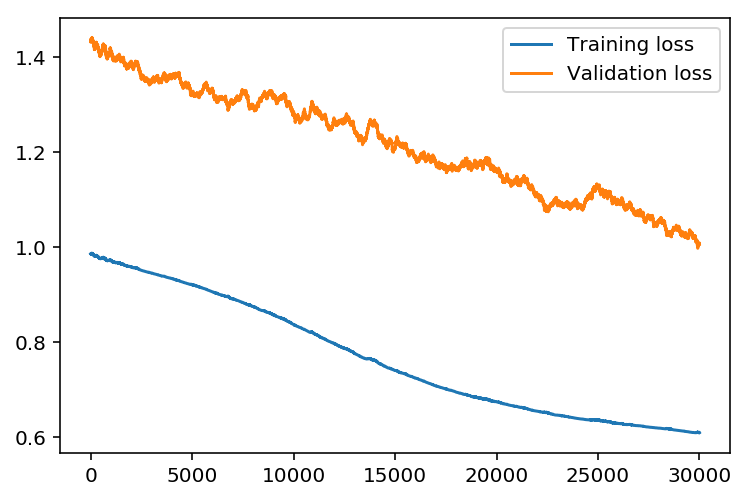

In [14]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

C:\Users\lorra\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


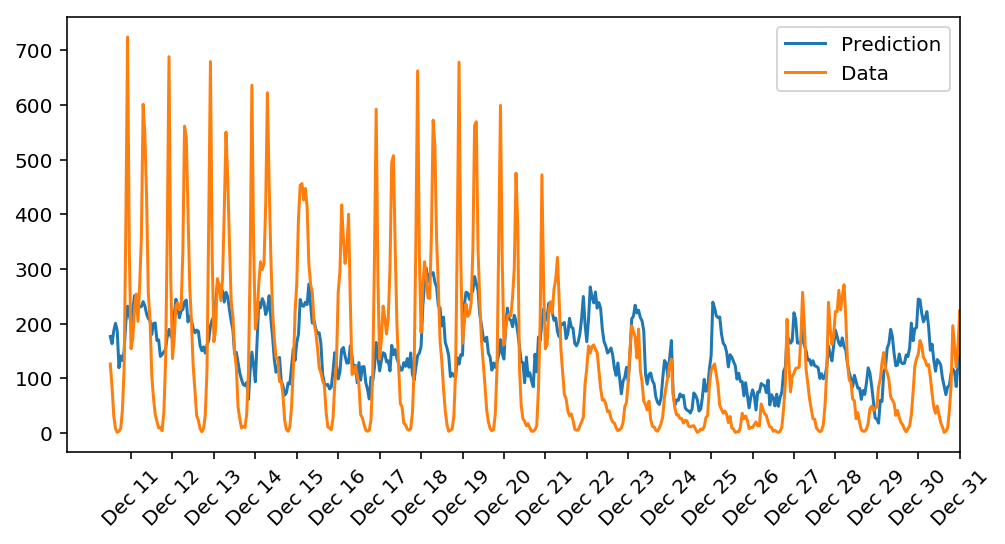

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?



#### Your answer below